# üè† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä ÏòàÏ∏° ÎåÄÌöå - KKH - EDA
> - Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÏÑùÌï¥Î≥¥Ïûê.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3Í∏∞
> - 2024.07.16.Ìôî ~ 2024.07.19.Í∏à 19:00

In [54]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance


# Î™®Îì† Ïó¥ÏùÑ ÌëúÏãúÌïòÎèÑÎ°ù ÏÑ§Ï†ï
pd.set_option('display.max_columns', None)

In [55]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')
kb = pd.read_csv('data/jaemyung_kb.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # ÏÑúÏö∏Ïãú Í∞ÄÍ≥ÑÎåÄÏ∂úÍ∑úÎ™®
# ÏÑúÏö∏Ïãú Í∞ÄÍ≥ÑÎåÄÏ∂úÍ∑úÎ™® Ï∂úÏ≤ò:  https://data.seoul.go.kr/dataList/10339/S/2/datasetView.do

## KB Î∂ÄÎèôÏÇ∞ ÏßÄÏàò Ï†ïÎ≥¥Î•º Ï∂îÍ∞ÄÌïúÎã§.

In [56]:
train = pd.merge(train, kb, left_on='Í≥ÑÏïΩÎÖÑÏõî', right_on='date', how='left')
train = train.drop(columns=['date'])

test = pd.merge(test, kb, left_on='Í≥ÑÏïΩÎÖÑÏõî', right_on='date', how='left')
test = test.drop(columns=['date'])

## ÏÑúÏö∏Ïãú Í∞ÄÍ≥ÑÎåÄÏ∂úÍ∑úÎ™® Ï†ïÎ≥¥Î•º Ï∂îÍ∞ÄÌïúÎã§.

- 2008ÎÖÑ Ìè¨Ìï®ÌïòÏó¨ 2023ÎÖÑ 12ÏõîÍπåÏßÄ ÏûêÎ£åÏù¥Îã§.
- Îî∞ÎùºÏÑú, train Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≥ÑÏïΩÎÖÑÏõîÏù¥ 200701 ~ 200712 ÏóêÎäî Í≤∞Ï∏°ÏπòÍ∞Ä Î∞úÏÉùÌï† Í≤ÉÏù¥Îã§.

In [57]:
loan.sample(2)

ÎÖÑÏõî  ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú
50   201203  200579.4
188  202309  407049.7

In [58]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ÎÖÑÏõî        192 non-null    int64  
 1   ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú  192 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


In [59]:
# 'Í≥ÑÏïΩÎÖÑÏõî'Í≥º 'ÎÖÑÏõî'Ïù¥ ÏùºÏπòÌïòÎäî Í≤ΩÏö∞ 'ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú' Ï†ïÎ≥¥Î•º trainÏóê Î≥ëÌï©
train = train.merge(loan, how='left', left_on='Í≥ÑÏïΩÎÖÑÏõî', right_on='ÎÖÑÏõî')
# 'ÎÖÑÏõî' Ïó¥ÏùÄ ÌïÑÏöî ÏóÜÏúºÎØÄÎ°ú ÏÇ≠Ï†ú
train.drop(columns=['ÎÖÑÏõî'], inplace=True)

In [60]:
test = test.merge(loan, how='left', left_on='Í≥ÑÏïΩÎÖÑÏõî', right_on='ÎÖÑÏõî')
test.drop(columns=['ÎÖÑÏõî'], inplace=True)

In [61]:
train.sample(2)

ÏãúÍµ∞Íµ¨    Î≤àÏßÄ    Î≥∏Î≤à   Î∂ÄÎ≤à       ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº  Ï∏µ  \
90047   ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Ïó≠Ï¥åÎèô  31-6  31.0  6.0  ÏïÑÍ∑∏ÎÑ§Ïä§ÌíçÎ¶ºÏïÑÏù¥Ïõê    88.01  201803   14  5   
812310  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô  18-1  18.0  1.0    ÎûòÎØ∏ÏïàÌçºÏä§Ìã∞ÏßÄ   117.12  201401   28  9   

        Í±¥Ï∂ïÎÖÑÎèÑ       ÎèÑÎ°úÎ™Ö  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê Í±∞ÎûòÏú†Ìòï Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)  \
90047   2009  ÏßÑÌù•Î°ú1Í∏∏ 28      NaN           -      -                NaN   
812310  2009  Î∞òÌè¨ÎåÄÎ°ú 275      NaN           -      -                ÏïÑÌååÌä∏   

           k-Ï†ÑÌôîÎ≤àÌò∏      k-Ìå©Ïä§Î≤àÌò∏  Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú) k-Í¥ÄÎ¶¨Î∞©Ïãù k-Î≥µÎèÑÏú†Ìòï k-ÎÇúÎ∞©Î∞©Ïãù  \
90047   023888867   023888782         NaN           Î∂ÑÏñë   ÏúÑÌÉÅÍ¥ÄÎ¶¨    Í≥ÑÎã®Ïãù   Í∞úÎ≥ÑÎÇúÎ∞©   
812310  025999960  25999935.0         NaN           Í∏∞ÌÉÄ   ÏúÑÌÉÅÍ¥ÄÎ¶¨    Í≥ÑÎã®Ïãù   ÏßÄÏó≠ÎÇúÎ∞©   

        k-Ï†ÑÏ≤¥ÎèôÏàò  k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)         k-ÏãúÌñâÏÇ¨          k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº  \
90047      1.0     64.0       ÌíçÎ¶ºÏÇ∞ÏóÖ     ÏÑúÎ∂ÄÏ¢ÖÌï©ÏãúÏû•(Ï£º)  2009-09-30 00:00:00.0   
812310    28.0   2444.0       ÏÇºÏÑ±Î¨ºÏÇ∞  Î∞òÌè¨Ï£ºÍ≥µ2Îã®ÏßÄÏû¨Í±¥Ï∂ïÏ°∞Ìï©  2009-07-14 00:00:00.0   

           k-Ïó∞Î©¥Ï†Å  k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å  k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å  k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)  \
90047    18427.0    6602.0    12639.0                 0.0   
812310  540103.0  279426.0   279426.0               512.0   

        k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)  k-85„é°~135„é°Ïù¥Ìïò  k-135„é°Ï¥àÍ≥º  \
90047                      0.0          64.0       NaN   
812310                   955.0         130.0       NaN   

                        k-ÌôàÌéòÏù¥ÏßÄ                 k-Îì±Î°ùÏùºÏûê                 k-ÏàòÏ†ïÏùºÏûê  \
90047                      NaN  2022-07-25 17:40:40.0  2024-07-11 08:06:14.0   
812310  bpfirstige.aptner.com/                    NaN  2023-09-23 16:19:01.0   

              Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏ Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú      Í±¥Ï∂ïÎ©¥Ï†Å    Ï£ºÏ∞®ÎåÄÏàò  \
90047              NaN      ÏúÑÌÉÅ     Îã®ÏùºÍ≥ÑÏïΩ      ÏúÑÌÉÅ   1972.28    64.0   
812310  114-82-63178-0      ÏúÑÌÉÅ     Ï¢ÖÌï©Í≥ÑÏïΩ      ÏúÑÌÉÅ  16981.06  4368.0   

       Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4                  Îã®ÏßÄÏäπÏù∏Ïùº ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú  \
90047                   Í∏∞ÌÉÄ  2024-04-16 11:15:44.0      Y       N   
812310                  ÏùòÎ¨¥  2016-01-12 11:48:03.0      Y       Y   

                        Îã®ÏßÄÏã†Ï≤≠Ïùº  target    Íµ¨    Îèô         Ï¢åÌëúX        Ï¢åÌëúY  \
90047   2024-04-16 10:33:51.0   45500  ÏùÄÌèâÍµ¨  Ïó≠Ï¥åÎèô  126.918964  37.602986   
812310  2013-03-07 09:46:56.0  187000  ÏÑúÏ¥àÍµ¨  Î∞òÌè¨Îèô  126.999261  37.502932   

               Îèô+ÏïÑÌååÌä∏Î™Ö 1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ 1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ìò∏ÏÑ†  1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨  5Î∂ÑÏù¥Ìïò_Ïó≠_Í∞úÏàò  \
90047   Ïó≠Ï¥åÎèô ÏïÑÍ∑∏ÎÑ§Ïä§ÌíçÎ¶ºÏïÑÏù¥Ïõê           Ïó≠Ï¥å          6Ìò∏ÏÑ†    474.095941          0   
812310    Î∞òÌè¨Îèô ÎûòÎØ∏ÏïàÌçºÏä§Ìã∞ÏßÄ          Ïã†Î∞òÌè¨          9Ìò∏ÏÑ†    299.115668          1   

        5Î∂ÑÏ¥àÍ≥º_10Î∂ÑÏù¥Ìïò_Ïó≠_Í∞úÏàò  kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò  ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú  
90047                 2    103.9  285382.6  
812310                3     29.7  202891.1

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118821
Data columns (total 62 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   ÏãúÍµ∞Íµ¨                     1118822 non-null  object 
 1   Î≤àÏßÄ                      1118597 non-null  object 
 2   Î≥∏Î≤à                      1118747 non-null  float64
 3   Î∂ÄÎ≤à                      1118747 non-null  float64
 4   ÏïÑÌååÌä∏Î™Ö                    1116696 non-null  object 
 5   Ï†ÑÏö©Î©¥Ï†Å(„é°)                 1118822 non-null  float64
 6   Í≥ÑÏïΩÎÖÑÏõî                    1118822 non-null  int64  
 7   Í≥ÑÏïΩÏùº                     1118822 non-null  int64  
 8   Ï∏µ                       1118822 non-null  int64  
 9   Í±¥Ï∂ïÎÖÑÎèÑ                    1118822 non-null  int64  
 10  ÎèÑÎ°úÎ™Ö                     1118822 non-null  object 
 11  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº                 5983 non-null     float64
 12  Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê              

In [63]:
train.columns

Index(['ÏãúÍµ∞Íµ¨', 'Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ',
       'ÎèÑÎ°úÎ™Ö', 'Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº', 'Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê', 'Í±∞ÎûòÏú†Ìòï', 'Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ', 'k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)',
       'k-Ï†ÑÌôîÎ≤àÌò∏', 'k-Ìå©Ïä§Î≤àÌò∏', 'Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob', 'k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)', 'k-Í¥ÄÎ¶¨Î∞©Ïãù', 'k-Î≥µÎèÑÏú†Ìòï',
       'k-ÎÇúÎ∞©Î∞©Ïãù', 'k-Ï†ÑÏ≤¥ÎèôÏàò', 'k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)', 'k-ÏãúÌñâÏÇ¨', 'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº',
       'k-Ïó∞Î©¥Ï†Å', 'k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)',
       'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)', 'k-85„é°~135„é°Ïù¥Ìïò', 'k-135„é°Ï¥àÍ≥º', 'k-ÌôàÌéòÏù¥ÏßÄ',
       'k-Îì±Î°ùÏùºÏûê', 'k-ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú',
       'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Í∏

In [64]:
print((train.isnull().mean() * 100).to_string())

ÏãúÍµ∞Íµ¨                        0.000000
Î≤àÏßÄ                         0.020110
Î≥∏Î≤à                         0.006703
Î∂ÄÎ≤à                         0.006703
ÏïÑÌååÌä∏Î™Ö                       0.190021
Ï†ÑÏö©Î©¥Ï†Å(„é°)                    0.000000
Í≥ÑÏïΩÎÖÑÏõî                       0.000000
Í≥ÑÏïΩÏùº                        0.000000
Ï∏µ                          0.000000
Í±¥Ï∂ïÎÖÑÎèÑ                       0.000000
ÎèÑÎ°úÎ™Ö                        0.000000
Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº                   99.465241
Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê                     0.000000
Í±∞ÎûòÏú†Ìòï                       0.000000
Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ                     0.000000
k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)        77.822120
k-Ï†ÑÌôîÎ≤àÌò∏                    22.518327
k-Ìå©Ïä§Î≤àÌò∏                    23.309070
Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob                80.389284
k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)              22.559889
k-Í¥ÄÎ¶¨Î∞©Ïãù                    22.559889
k-Î≥µÎèÑÏú†Ìòï                    22.568380
k-ÎÇúÎ∞©Î∞

## ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

In [65]:
test.sample(2)

ÏãúÍµ∞Íµ¨   Î≤àÏßÄ     Î≥∏Î≤à   Î∂ÄÎ≤à        ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº   Ï∏µ  \
743   ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎèôÍµ¨ Í≥†ÎçïÎèô  688  688.0  0.0  ÎûòÎØ∏ÏïàÌûêÏä§ÌÖåÏù¥Ìä∏Í≥†Îçï    84.83  202308   22  20   
1166  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎèôÍµ¨ Ï≤úÌò∏Îèô  528  528.0  0.0       Ï≤úÌò∏ÎèôÏÇºÏÑ±   114.65  202307    5   1   

      Í±¥Ï∂ïÎÖÑÎèÑ         ÎèÑÎ°úÎ™Ö  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº    Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê  Í±∞ÎûòÏú†Ìòï  Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)  \
743   2016  ÏïÑÎ¶¨ÏàòÎ°ú50Í∏∏ 50      NaN            Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ Í∞ïÎèôÍµ¨                NaN   
1166  1997    ÏÑ±ÏïàÎ°ú25Í∏∏ 6      NaN  20230922  Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ Í∞ïÎèôÍµ¨                NaN   

         k-Ï†ÑÌôîÎ≤àÌò∏     k-Ìå©Ïä§Î≤àÌò∏  Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú) k-Í¥ÄÎ¶¨Î∞©Ïãù k-Î≥µÎèÑÏú†Ìòï k-ÎÇúÎ∞©Î∞©Ïãù  \
743   024818729  024818732         NaN           Í∏∞ÌÉÄ   ÏúÑÌÉÅÍ¥ÄÎ¶¨    Í≥ÑÎã®Ïãù   ÏßÄÏó≠ÎÇúÎ∞©   
1166  024878518  024878584        77.0           Î∂ÑÏñë   ÏúÑÌÉÅÍ¥ÄÎ¶¨    ÌòºÌï©Ïãù   Í∞úÎ≥ÑÎÇúÎ∞©   

      k-Ï†ÑÏ≤¥ÎèôÏàò  k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)              k-ÏãúÌñâÏÇ¨          k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº  \
743     51.0   3658.0     ÏÇºÏÑ±, ÌòÑÎåÄ  Í≥†ÎçïÏãúÏòÅÏïÑÌååÌä∏ Ï£ºÌÉùÏû¨Í±¥Ï∂ïÏÇ¨ÏóÖÏ°∞Ìï©  2016-12-29 00:00:00.0   
1166     3.0    396.0    ÏÇºÏÑ±Î¨ºÏÇ∞(Ï£º)            ÏÇºÏÑ±Î¨ºÏÇ∞(Ï£º)  1997-05-26 00:00:00.0   

         k-Ïó∞Î©¥Ï†Å  k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å  k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å  k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)  \
743   673476.0  289808.0   396458.0              1074.0   
1166   49295.0   33635.0    33635.0               140.0   

      k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)  k-85„é°~135„é°Ïù¥Ìïò  k-135„é°Ï¥àÍ≥º              k-ÌôàÌéòÏù¥ÏßÄ  \
743                   2105.0         472.0       NaN  rhgd.aptner.com/v2   
1166                   138.0         118.0       NaN                 NaN   

                     k-Îì±Î°ùÏùºÏûê                 k-ÏàòÏ†ïÏùºÏûê     Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏ Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú  \
743   2017-04-18 05:55:51.0  2024-07-11 19:55:22.0  91711936281      ÏúÑÌÉÅ   
1166                    NaN  2024-07-11 20:38:51.0   3178273784      ÏúÑÌÉÅ   

     ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú    Í±¥Ï∂ïÎ©¥Ï†Å   Ï£ºÏ∞®ÎåÄÏàò Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4  \
743      Ï¢ÖÌï©Í≥ÑÏïΩ      ÏúÑÌÉÅ     0.0    0.0                  ÏùòÎ¨¥   
1166     Îã®ÏùºÍ≥ÑÏïΩ      ÏúÑÌÉÅ  2593.0  504.0                  ÏùòÎ¨¥   

                      Îã®ÏßÄÏäπÏù∏Ïùº ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú                  Îã®ÏßÄÏã†Ï≤≠Ïùº         Ï¢åÌëúX  \
743   2019-05-29 18:30:03.0      Y       N  2017-04-18 05:55:51.0  127.147102   
1166  2017-03-29 09:52:51.0      Y       N  2013-03-07 09:46:30.0  127.135257   

            Ï¢åÌëúY    Íµ¨    Îèô          Îèô+ÏïÑÌååÌä∏Î™Ö 1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ 1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ìò∏ÏÑ†  \
743   37.558958  Í∞ïÎèôÍµ¨  Í≥†ÎçïÎèô  Í≥†ÎçïÎèô ÎûòÎØ∏ÏïàÌûêÏä§ÌÖåÏù¥Ìä∏Í≥†Îçï           Í≥†Îçï          5Ìò∏ÏÑ†   
1166  37.538718  Í∞ïÎèôÍµ¨  Ï≤úÌò∏Îèô       Ï≤úÌò∏Îèô Ï≤úÌò∏ÎèôÏÇºÏÑ±           Í∞ïÎèô          5Ìò∏ÏÑ†   

      1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨  5Î∂ÑÏù¥Ìïò_Ïó≠_Í∞úÏàò  5Î∂ÑÏ¥àÍ≥º_10Î∂ÑÏù¥Ìïò_Ïó≠_Í∞úÏàò  kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò  ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú  
743     761.225313          0                0     46.0  406315.8  
1166    406.055831          0                2     38.0  404538.4

In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 0 to 9271
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ÏãúÍµ∞Íµ¨                     9272 non-null   object 
 1   Î≤àÏßÄ                      9272 non-null   object 
 2   Î≥∏Î≤à                      9272 non-null   float64
 3   Î∂ÄÎ≤à                      9272 non-null   float64
 4   ÏïÑÌååÌä∏Î™Ö                    9272 non-null   object 
 5   Ï†ÑÏö©Î©¥Ï†Å(„é°)                 9272 non-null   float64
 6   Í≥ÑÏïΩÎÖÑÏõî                    9272 non-null   int64  
 7   Í≥ÑÏïΩÏùº                     9272 non-null   int64  
 8   Ï∏µ                       9272 non-null   int64  
 9   Í±¥Ï∂ïÎÖÑÎèÑ                    9272 non-null   int64  
 10  ÎèÑÎ°úÎ™Ö                     9272 non-null   object 
 11  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº                 212 non-null    float64
 12  Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê                  9272 non-null   object 
 13  Í

In [67]:
test.columns

Index(['ÏãúÍµ∞Íµ¨', 'Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ',
       'ÎèÑÎ°úÎ™Ö', 'Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº', 'Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê', 'Í±∞ÎûòÏú†Ìòï', 'Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ', 'k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)',
       'k-Ï†ÑÌôîÎ≤àÌò∏', 'k-Ìå©Ïä§Î≤àÌò∏', 'Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob', 'k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)', 'k-Í¥ÄÎ¶¨Î∞©Ïãù', 'k-Î≥µÎèÑÏú†Ìòï',
       'k-ÎÇúÎ∞©Î∞©Ïãù', 'k-Ï†ÑÏ≤¥ÎèôÏàò', 'k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)', 'k-ÏãúÌñâÏÇ¨', 'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº',
       'k-Ïó∞Î©¥Ï†Å', 'k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)',
       'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)', 'k-85„é°~135„é°Ïù¥Ìïò', 'k-135„é°Ï¥àÍ≥º', 'k-ÌôàÌéòÏù¥ÏßÄ',
       'k-Îì±Î°ùÏùºÏûê', 'k-ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú',
       'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Í∏

## ÏßÄÌïòÏ≤† Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

In [68]:
subway.head(2)

Ïó≠ÏÇ¨_ID Ïó≠ÏÇ¨Î™Ö   Ìò∏ÏÑ†         ÏúÑÎèÑ          Í≤ΩÎèÑ
0   9996  ÎØ∏ÏÇ¨  5Ìò∏ÏÑ†  37.560927  127.193877
1   9995  Í∞ïÏùº  5Ìò∏ÏÑ†  37.557490  127.175930

## Î≤ÑÏä§ Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

In [69]:
bus.head(2)

ÎÖ∏Îìú ID  Ï†ïÎ•òÏÜåÎ≤àÌò∏         Ï†ïÎ•òÏÜåÎ™Ö         XÏ¢åÌëú        YÏ¢åÌëú Ï†ïÎ•òÏÜå ÌÉÄÏûÖ
0  100000001   1001      Ï¢ÖÎ°ú2Í∞ÄÏÇ¨Í±∞Î¶¨  126.987752  37.569808   Ï§ëÏïôÏ∞®Î°ú
1  100000002   1002  Ï∞ΩÍ≤ΩÍ∂Å.ÏÑúÏö∏ÎåÄÌïôÍµêÎ≥ëÏõê  126.996566  37.579183   Ï§ëÏïôÏ∞®Î°ú

## train ÌîºÏ≤ò ÏÑ∏Î∂Ä Î∂ÑÏÑù

In [70]:
def eda_kkh(df: pd.DataFrame):
    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc, df.describe().T.drop('count',axis=1)],axis=1)
    return desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
        .bar(subset=['mean'],color='green')\
        .bar(subset=['max'],color='red')\
        .bar(subset=['min'], color='purple')

eda_kkh(train)

## test ÌîºÏ≤ò ÏÑ∏Î∂Ä Î∂ÑÏÑù

In [71]:
eda_kkh(test)

## Î≥∏Í≤©Ï†ÅÏù∏ EDA

In [72]:
train['Í≥ÑÏïΩÎÖÑ'] = train['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4]).astype('int')
train['Í≥ÑÏïΩÏõî'] = train['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[4:]).astype('int')

test['Í≥ÑÏïΩÎÖÑ'] = test['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4]).astype('int')
test['Í≥ÑÏïΩÏõî'] = test['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[4:]).astype('int')

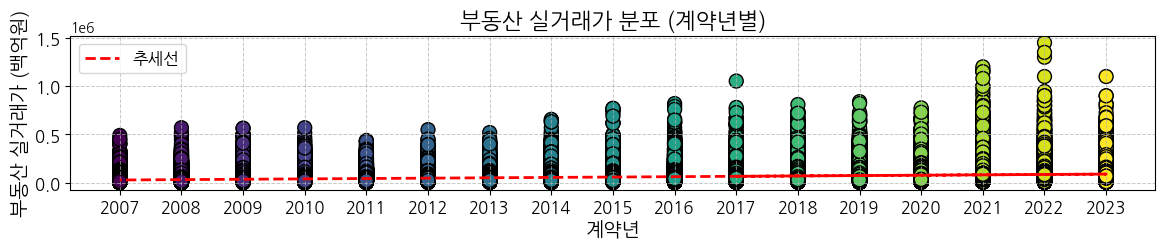

In [73]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'Í≥ÑÏïΩÎÖÑ'Í≥º 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Í≥ÑÏïΩÎÖÑ', 'target']].dropna()

# ÏÉâÏÉÅ Îßµ ÏÑ§Ï†ï
cmap = plt.get_cmap('viridis')

# 'Í≥ÑÏïΩÎÖÑ'Ïùò Î≤îÏúÑÎ•º 0ÏóêÏÑú 1 ÏÇ¨Ïù¥Î°ú Ï†ïÍ∑úÌôîÌïòÏó¨ ÏÉâÏÉÅÏóê Îß§Ìïë
norm = plt.Normalize(data['Í≥ÑÏïΩÎÖÑ'].min(), data['Í≥ÑÏïΩÎÖÑ'].max())

# ÌöåÍ∑Ä Î∂ÑÏÑù
coefficients = np.polyfit(data['Í≥ÑÏïΩÎÖÑ'], data['target'], 1)  # 1Ï∞® Îã§Ìï≠Ïãù(ÏßÅÏÑ†) ÌöåÍ∑Ä
polynomial = np.poly1d(coefficients)
regression_line = polynomial(data['Í≥ÑÏïΩÎÖÑ'])

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(14, 2))
scatter = plt.scatter(data['Í≥ÑÏïΩÎÖÑ'], data['target'], c=data['Í≥ÑÏïΩÎÖÑ'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# Ï∂îÏÑ∏ÏÑ† Í∑∏Î¶¨Í∏∞
plt.plot(data['Í≥ÑÏïΩÎÖÑ'], regression_line, color='red', linewidth=2, linestyle='--', label='Ï∂îÏÑ∏ÏÑ†')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Î∂ÑÌè¨ (Í≥ÑÏïΩÎÖÑÎ≥Ñ)', fontsize=16, fontweight='bold')
plt.xlabel('Í≥ÑÏïΩÎÖÑ', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (Î∞±ÏñµÏõê)', fontsize=14)

# xÏ∂ï ÎààÍ∏à ÏÑ§Ï†ï
years = sorted(data['Í≥ÑÏïΩÎÖÑ'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Î∞è Î≤îÎ°Ä ÏÑ§Ï†ï
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()


###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- Î™®Îì† Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÎÇ¥Ïó≠ÏùÑ ÎÖÑÎèÑÎ≥ÑÎ°ú ÌëúÏãúÌïú Ï∞®Ìä∏ÏûÑ.
- ÏµúÍ≥† Í∞ÄÍ≤©ÏúºÎ°ú Í±∞ÎûòÎêú Í±¥ÏùÄ 2022ÎÖÑÎèÑÏóê Î∂ÑÌè¨Ìï®.

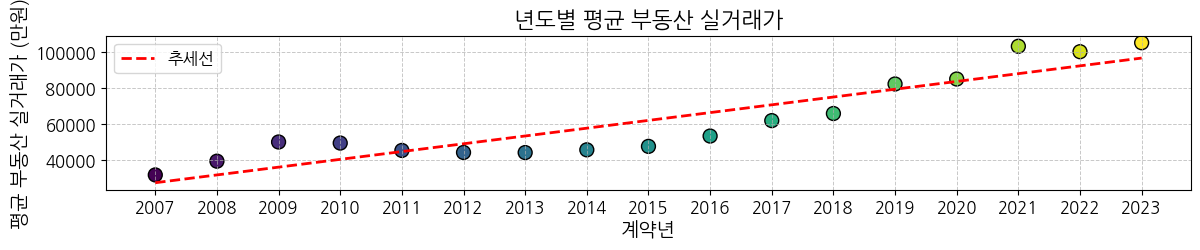

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'Í≥ÑÏïΩÎÖÑ'Í≥º 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Í≥ÑÏïΩÎÖÑ', 'target']].dropna()

# ÎÖÑÎèÑÎ≥Ñ ÌèâÍ∑† Í∞ÄÍ≤© Í≥ÑÏÇ∞
yearly_avg_price = data.groupby('Í≥ÑÏïΩÎÖÑ')['target'].mean().sort_index()

# ÏÉâÏÉÅ Îßµ ÏÑ§Ï†ï
cmap = plt.get_cmap('viridis')

# 'Í≥ÑÏïΩÎÖÑ'Ïùò Î≤îÏúÑÎ•º 0ÏóêÏÑú 1 ÏÇ¨Ïù¥Î°ú Ï†ïÍ∑úÌôîÌïòÏó¨ ÏÉâÏÉÅÏóê Îß§Ìïë
norm = plt.Normalize(yearly_avg_price.index.min(), yearly_avg_price.index.max())

# ÌöåÍ∑Ä Î∂ÑÏÑù
coefficients = np.polyfit(yearly_avg_price.index, yearly_avg_price.values, 1)  # 1Ï∞® Îã§Ìï≠Ïãù(ÏßÅÏÑ†) ÌöåÍ∑Ä
polynomial = np.poly1d(coefficients)
regression_line = polynomial(yearly_avg_price.index)

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(14, 2))
scatter = plt.scatter(yearly_avg_price.index, yearly_avg_price.values, c=yearly_avg_price.index, cmap=cmap, norm=norm, s=100, edgecolor='black')

# Ï∂îÏÑ∏ÏÑ† Í∑∏Î¶¨Í∏∞
plt.plot(yearly_avg_price.index, regression_line, color='red', linewidth=2, linestyle='--', label='Ï∂îÏÑ∏ÏÑ†')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('ÎÖÑÎèÑÎ≥Ñ ÌèâÍ∑† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä', fontsize=16, fontweight='bold')
plt.xlabel('Í≥ÑÏïΩÎÖÑ', fontsize=14)
plt.ylabel('ÌèâÍ∑† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (ÎßåÏõê)', fontsize=14)

# xÏ∂ï ÎààÍ∏à ÏÑ§Ï†ï
years = sorted(yearly_avg_price.index)
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Î∞è Î≤îÎ°Ä ÏÑ§Ï†ï
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()


###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- ÎÖÑÎèÑÎ≥ÑÎ°ú Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞ÄÏùò ÌèâÍ∑†ÏùÑ Íµ¨Î∂ÑÌïú Ï∞®Ìä∏ÏûÑ.
- Íµ≠ÏÜåÏ†ÅÏúºÎ°ú ÌïòÎùΩ ÌïòÍ∏∞ÎèÑ ÌñàÏúºÎÇò, Ï†ÑÎ∞òÏ†ÅÏúºÎ°úÎäî ÏÉÅÏäπ Ï∂îÏÑ∏ÏûÑ.
- Í≥ÑÏïΩÎÖÑÎèÑÏôÄ target(Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä)Îäî ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ°ú Î≥¥ÏûÑ.

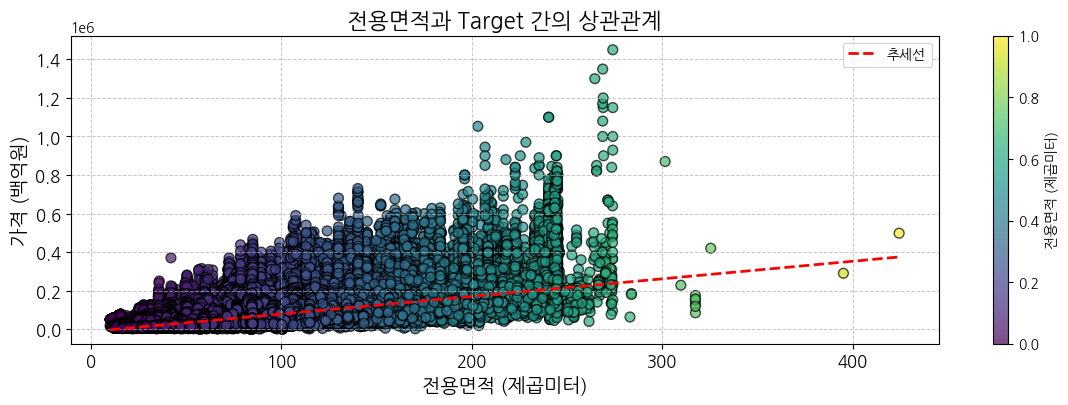

In [75]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'area'ÏôÄ 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'target']].dropna()

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].min(), data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].max())
colors = cmap(norm(data['Ï†ÑÏö©Î©¥Ï†Å(„é°)']))

plt.figure(figsize=(14, 4))
scatter = plt.scatter(data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'], data['target'], c=colors, s=50, edgecolor='black', alpha=0.7)

coefficients = np.polyfit(data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'], data['target'], 1)  # 1Ï∞® ÏÑ†Ìòï ÌöåÍ∑Ä
polynomial = np.poly1d(coefficients)
x_values = np.linspace(data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].min(), data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].max(), 100)
y_values = polynomial(x_values)

plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=2, label='Ï∂îÏÑ∏ÏÑ†')
plt.title('Ï†ÑÏö©Î©¥Ï†ÅÍ≥º Target Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ', fontsize=16, fontweight='bold')
plt.xlabel('Ï†ÑÏö©Î©¥Ï†Å (Ï†úÍ≥±ÎØ∏ÌÑ∞)', fontsize=14)
plt.ylabel('Í∞ÄÍ≤© (Î∞±ÏñµÏõê)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(scatter, label='Ï†ÑÏö©Î©¥Ï†Å (Ï†úÍ≥±ÎØ∏ÌÑ∞)', orientation='vertical')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- ÏùºÎ∞òÏ†ÅÏúºÎ°ú, Ï†ÑÏö©Î©¥Ï†ÅÏù¥ ÌÅ¥ ÏàòÎ°ù target(Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä) Í∞íÏù¥ ÎÜíÏùå.
- Ï†ÑÏö©Î©¥Ï†ÅÍ≥º target Í∞íÏùÄ ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ°ú Î≥¥ÏûÑ.

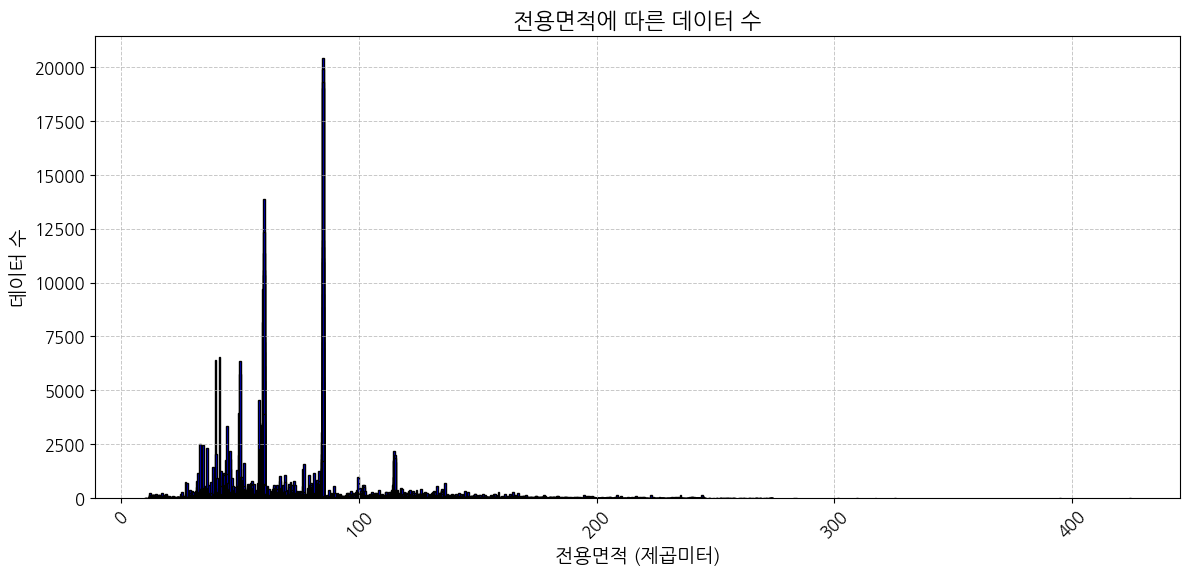

In [76]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'area'ÏôÄ 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Ï†ÑÏö©Î©¥Ï†Å(„é°)']].dropna()

# Ï†ÑÏö©Î©¥Ï†ÅÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
area_counts = data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].value_counts().sort_index()

# ÎùºÏù∏ Ï∞®Ìä∏Î•º Í∑∏Î¶ΩÎãàÎã§.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï†ÑÏö©Î©¥Ï†ÅÏóê Îî∞Î•∏ Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=16, fontweight='bold')
plt.xlabel('Ï†ÑÏö©Î©¥Ï†Å (Ï†úÍ≥±ÎØ∏ÌÑ∞)', fontsize=14)
plt.ylabel('Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12, rotation=45)  # xÏ∂ï Î†àÏù¥Î∏îÏùÑ Îçî Ïûò Î≥¥Ïù¥ÎèÑÎ°ù ÌöåÏ†Ñ
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- Íµ≠ÎØº ÌèâÏàòÎ°ú Î∂àÎ¶¨Ïö∞Îäî 84„é° Î∞è 59„é° Î∂ÄÍ∑ºÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Í∞ÄÏû• ÎßéÏïÑ Î≥¥ÏûÑ.
- Ìï¥Îãπ Î∂ÄÍ∑ºÏùÑ ÌôïÎåÄÌï¥Î≥¥Ïûê.

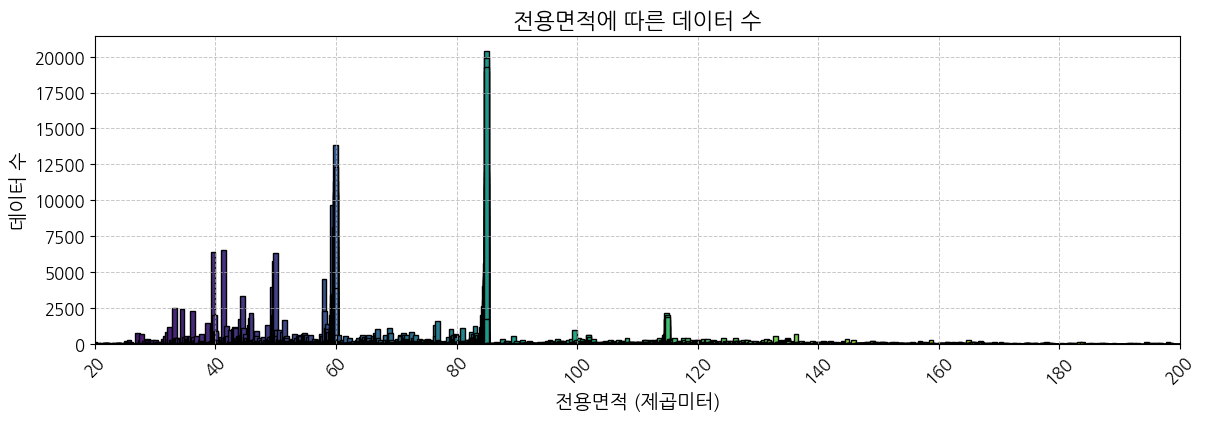

In [77]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'area'ÏôÄ 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Ï†ÑÏö©Î©¥Ï†Å(„é°)']].dropna()

# Ï†ÑÏö©Î©¥Ï†ÅÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
area_counts = data['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].value_counts().sort_index()

# ÏÉâÏÉÅ Îßµ ÏÑ†ÌÉù (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('viridis')

# Í∞Å ÎßâÎåÄÏùò ÏÉâÏÉÅÏùÑ ÏÉâÏÉÅ ÎßµÏóêÏÑú Í∞ÄÏ†∏Ïò§Í∏∞
colors = cmap(np.linspace(0, 1, len(area_counts)))

plt.figure(figsize=(14, 4))
bars = plt.bar(area_counts.index, area_counts.values, color=colors, edgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï†ÑÏö©Î©¥Ï†ÅÏóê Îî∞Î•∏ Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=16, fontweight='bold')
plt.xlabel('Ï†ÑÏö©Î©¥Ï†Å (Ï†úÍ≥±ÎØ∏ÌÑ∞)', fontsize=14)
plt.ylabel('Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12, rotation=45)  # xÏ∂ï Î†àÏù¥Î∏îÏùÑ Îçî Ïûò Î≥¥Ïù¥ÎèÑÎ°ù ÌöåÏ†Ñ
plt.yticks(fontsize=12)

# xÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
plt.xlim(20, 200)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- 59„é°(¬±1) Î∞è 84„é°(¬±1) Î©¥Ï†ÅÏù¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∞®ÏßÄÌïòÎäî ÎπÑÏú®: ÏïΩ 53%
- 90„é° Ïù¥ÌïòÏùò Î©¥Ï†ÅÏù¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∞®ÏßÄÌïòÎäî ÎπÑÏú®: ÏïΩ 83%
- ÎπÑÏä∑Ìïú Í∞íÏùÑ Í∑∏Î£πÌôî ÌïòÏó¨ Î∂ÑÏÑùÌï† ÌïÑÏöîÍ∞Ä Î≥¥ÏûÑ.

In [78]:
# Ï†ÑÏö©Î©¥Ï†Å Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ
area_filtered = train[(58 <= train['Ï†ÑÏö©Î©¥Ï†Å(„é°)']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] <= 60) |
                      (83 <= train['Ï†ÑÏö©Î©¥Ï†Å(„é°)']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] <= 85)]

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàòÏôÄ ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
total_count = len(train)
filtered_count = len(area_filtered)

# ÎπÑÏú® Í≥ÑÏÇ∞
percentage = (filtered_count / total_count) * 100

print(f'Î©¥Ï†ÅÏù¥ 58~60„é° Î∞è 83~85„é°Ïù∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®: {percentage:.2f}%')

Î©¥Ï†ÅÏù¥ 58~60„é° Î∞è 83~85„é°Ïù∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®: 52.64%


In [79]:
# Ï†ÑÏö©Î©¥Ï†Å Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ
area_filtered = train[(train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] <= 90)]
total_count = len(train)
filtered_count = len(area_filtered)
percentage = (filtered_count / total_count) * 100
print(f'Î©¥Ï†ÅÏù¥ 90„é° Ïù¥ÌïòÏù∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®: {percentage:.2f}%')

Î©¥Ï†ÅÏù¥ 90„é° Ïù¥ÌïòÏù∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®: 82.92%


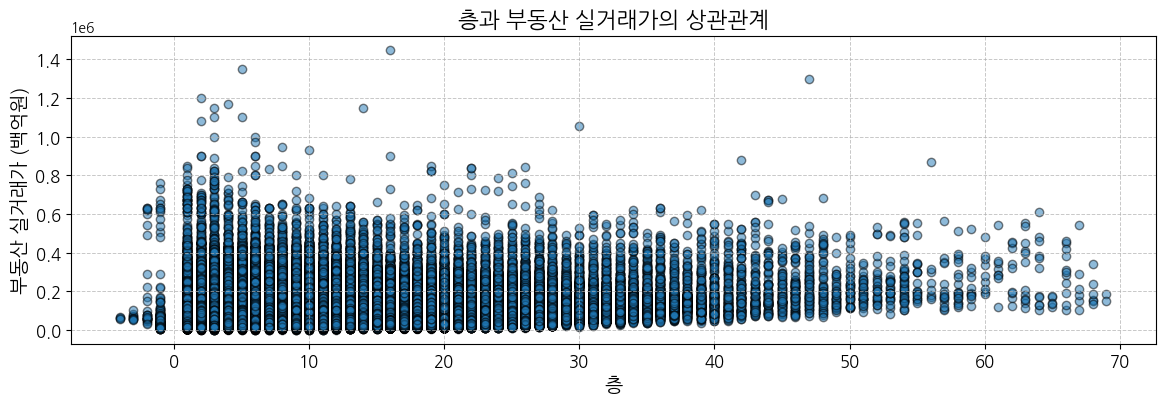

In [80]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'Ï∏µ'Í≥º 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Ï∏µ', 'target']].dropna()

plt.figure(figsize=(14, 4))
plt.scatter(data['Ï∏µ'], data['target'], alpha=0.5, edgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï∏µÍ≥º Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞ÄÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ', fontsize=16, fontweight='bold')
plt.xlabel('Ï∏µ', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (Î∞±ÏñµÏõê)', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- Ï∏µ ÌîºÏ≤òÎ•º Î≥∏ Ï∞®Ìä∏Î°ú Î∂ÑÏÑùÌñàÏùÑ ÎïåÎäî, ÌäπÎ≥ÑÌïú ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÍ∏∞ Ïñ¥Î†§ÏõÄ.
- Îã§Îßå, Ï∏µÏù¥ ÎÜíÏïÑÏßà ÏàòÎ°ù, Ï†ÄÎ†¥Ìïú Î∂ÄÎèôÏÇ∞ÏùÄ ÏÇ¨ÎùºÏßêÏù¥ Î≥¥ÏûÑ.
- ÎçîÏö± Ïã¨ÎèÑÏûàÎäî Î∂ÑÏÑùÏù¥ ÌïÑÏöîÌï®.

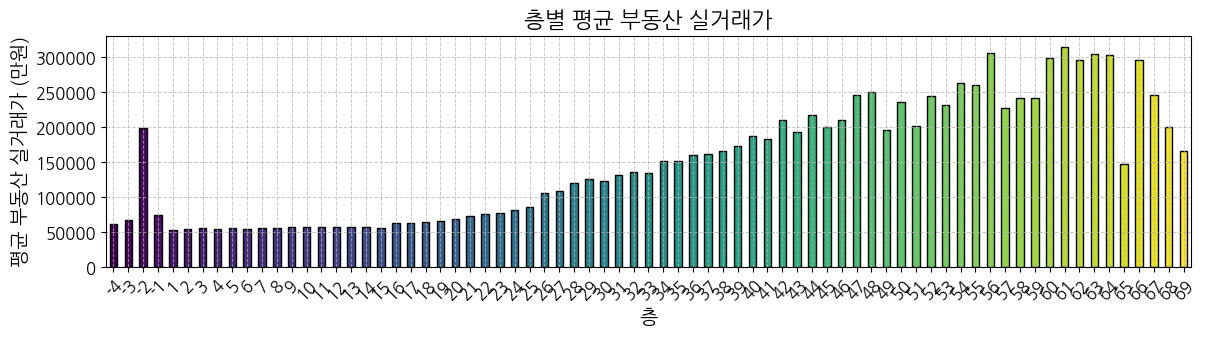

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'Ï∏µ'Í≥º 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['Ï∏µ', 'target']].dropna()

# Ï∏µÎ≥Ñ ÌèâÍ∑† Í±∞ÎûòÍ∞ÄÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
mean_prices_per_floor = data.groupby('Ï∏µ')['target'].mean()

# ÏÉâÏÉÅ Îßµ ÏÑ†ÌÉù (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('viridis')

# Í∞Å ÎßâÎåÄÏùò ÏÉâÏÉÅÏùÑ ÏÉâÏÉÅ ÎßµÏóêÏÑú Í∞ÄÏ†∏Ïò§Í∏∞
colors = cmap(np.linspace(0, 1, len(mean_prices_per_floor)))

plt.figure(figsize=(14, 3))
mean_prices_per_floor.plot(kind='bar', color=colors, edgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï∏µÎ≥Ñ ÌèâÍ∑† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä', fontsize=16, fontweight='bold')
plt.xlabel('Ï∏µ', fontsize=14)
plt.ylabel('ÌèâÍ∑† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (ÎßåÏõê)', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()


###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- ÏùºÎ∞òÏ†ÅÏúºÎ°ú, Ï∏µÏù¥ ÎÜíÏùÑÏàòÎ°ù Î∂ÄÎèôÏÇ∞ Í∞ÄÍ≤©Ïù¥ ÎÜíÏïÑÏßÄÎäî Í≤ΩÌñ•ÏùÑ Î≥¥ÏûÑ.
- 67Ï∏µ Ïù¥ÏÉÅÏùò Í≥†Ï∏µÏóêÏÑú Í∞ÄÍ≤©Ïù¥ Îã§Ïãú ÌïòÎùΩÌïòÎäî Í≤ΩÌñ•Ïù¥ Î≥¥Ïù¥ÎäîÎç∞,
- Îç∞Ïù¥ÌÑ∞ Í∞úÏàòÍ∞Ä Ï†ÅÏúºÎãà, Í≤ΩÌñ•ÏÑ±ÏùÑ Ìï®Î∂ÄÎ°ú ÏÜçÎã®ÌïòÍ∏∞ Ïñ¥Î†§Ïö¥ Î∂ÄÎ∂ÑÏûÑ.
- (Îç∞Ïù¥ÌÑ∞ Ïàò:  67Ï∏µ_6Í∞ú,  68Ï∏µ_6Í∞ú,  69Ï∏µ_2Í∞ú)

In [82]:
floor = 2
print(f'{floor}Ï∏µ ÎØ∏Îßå: ', train[(floor == train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean())
print(f'{floor}Ï∏µ Ïù¥ÏÉÅ: ', train[(floor < train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean())

2Ï∏µ ÎØ∏Îßå:  53645.097589469995
2Ï∏µ Ïù¥ÏÉÅ:  58679.398935340454


In [83]:
print(f'-4Ï∏µ: {train[train["Ï∏µ"] == -4].shape[0]}')
print(f'-3Ï∏µ: {train[train["Ï∏µ"] == -3].shape[0]}')
print(f'-2Ï∏µ: {train[train["Ï∏µ"] == -2].shape[0]}')
print(f'-1Ï∏µ: {train[train["Ï∏µ"] == -1].shape[0]}')
print(f'65Ï∏µ: {train[train["Ï∏µ"] == 65].shape[0]}')
print(f'66Ï∏µ: {train[train["Ï∏µ"] == 66].shape[0]}')
print(f'67Ï∏µ: {train[train["Ï∏µ"] == 67].shape[0]}')
print(f'68Ï∏µ: {train[train["Ï∏µ"] == 68].shape[0]}')
print(f'69Ï∏µ: {train[train["Ï∏µ"] == 69].shape[0]}')

-4Ï∏µ: 4
-3Ï∏µ: 10
-2Ï∏µ: 31
-1Ï∏µ: 216
65Ï∏µ: 5
66Ï∏µ: 11
67Ï∏µ: 6
68Ï∏µ: 6
69Ï∏µ: 2


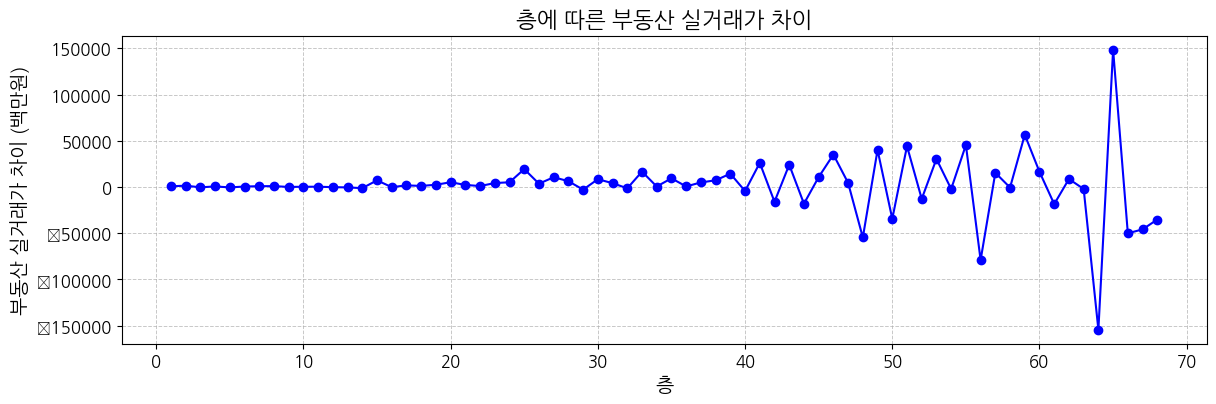

In [84]:
floor_diff_value_list = dict()
for floor in range(1, 100, 1):
    diff = train[((floor+1) == train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean() - train[(floor == train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)


plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï∏µÏóê Îî∞Î•∏ Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Ï∞®Ïù¥', fontsize=16, fontweight='bold')
plt.xlabel('Ï∏µ', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Ï∞®Ïù¥ (Î∞±ÎßåÏõê)', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- Î∞îÎ°ú ÏïÑÎûòÏ∏µÍ≥º Î∞îÎ°ú ÏúóÏ∏µÏùò Í∞ÄÍ≤©ÏùÑ ÎπÑÍµêÌïú Ï∞®Ìä∏Ïù¥Îã§.
- ÏòàÎ•º Îì§Ïñ¥, 30Ï∏µÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÌïúÎã§Î©¥, 30Ï∏µÍ≥º 29Ï∏µÏùò Í∞ÄÍ≤©Ï∞®Ïù¥Î•º ÎπÑÍµêÌïú Í≤ÉÏù¥Îã§.
- 1Í∞ú Ï∏µÏùò Ï∞®Ïù¥Í∞íÏù¥Í∏∞Ïóê ÌÅ∞ Ï∞®Ïù¥Í∞Ä ÏóÜÏñ¥ Î≥¥Ïù¥Îã§Í∞Ä, 40Ï∏µ Ïù¥ÏÉÅ Î∂ÄÌÑ∞Îäî Í∞ÄÍ≤© Ï∞®Ïù¥Í∞Ä Îì§Ï£ΩÎÇ†Ï£ΩÌïòÎã§.

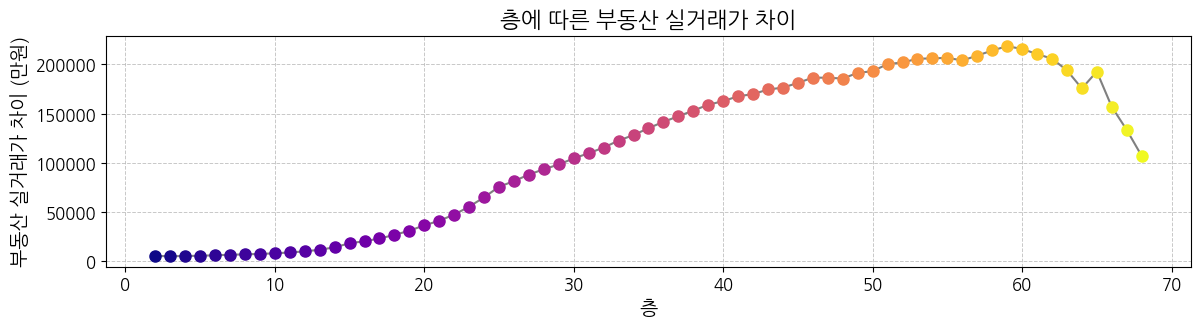

In [85]:
floor_diff_value_list = dict()
for floor in range(2, 100, 1):
    diff = train[(floor < train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean() - train[(floor >= train['Ï∏µ']) & (train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)


# ÏÉâÏÉÅ Îßµ ÏÑ†ÌÉù (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('plasma')

# Í∞Å Ï†êÏùò ÏÉâÏÉÅÏùÑ ÏÉâÏÉÅ ÎßµÏóêÏÑú Í∞ÄÏ†∏Ïò§Í∏∞
colors = cmap(np.linspace(0, 1, len(floor_diff_value_list)))

plt.figure(figsize=(14, 3))

# ÎùºÏù∏ Í∑∏Î¶¨Í∏∞
plt.plot(list(floor_diff_value_list.keys()), list(floor_diff_value_list.values()), marker='o', linestyle='-', color='gray')

# Í∞Å Ï†êÏóê ÏÉâÏÉÅ Ï†ÅÏö©
for i, (x, y) in enumerate(floor_diff_value_list.items()):
    plt.plot(x, y, marker='o', color=colors[i], markersize=8)

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï∏µÏóê Îî∞Î•∏ Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Ï∞®Ïù¥', fontsize=16, fontweight='bold')
plt.xlabel('Ï∏µ', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Ï∞®Ïù¥ (ÎßåÏõê)', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- ÏïÑÎûòÏ∏µ Ïù¥ÌïòÏôÄ ÏúóÏ∏µ Ïù¥ÏÉÅÏùò ÌèâÍ∑†Í∞ÄÍ≤©ÏùÑ ÎπÑÍµêÌïú Ï∞®Ìä∏Ïù¥Îã§.
- ÏòàÎ•º Îì§Ïñ¥, 30Ï∏µÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÌïúÎã§Î©¥, 30Ï∏µ Ïù¥ÏÉÅÏùò ÌèâÍ∑†Í∞ÄÍ≤©Í≥º  29Ï∏µ Ïù¥ÌïòÏùò ÌèâÍ∑†Í∞ÄÍ≤© Ï∞®Ïù¥Î•º ÎπÑÍµêÌïú Í≤ÉÏù¥Îã§.
- 60Ï∏µ Î∂ÄÌÑ∞Îäî Í∞ÄÍ≤©Ïù¥ Îñ®Ïñ¥ÏßÄÎäî Í≤ÉÏ≤òÎüº Î≥¥Ïù¥ÎäîÎç∞, Îç∞Ïù¥ÌÑ∞Í∞Ä ÎßéÏù¥ ÏóÜÎäî Íµ¨Í∞ÑÏù¥ÎùºÏÑú 60Ï∏µ Ïù¥ÏÉÅÏùÄ Î≥∏ Ï∞®Ìä∏ÎßåÏúºÎ°ú ÏÜçÎã®ÌïòÎ©¥ Ïïà ÎêúÎã§.

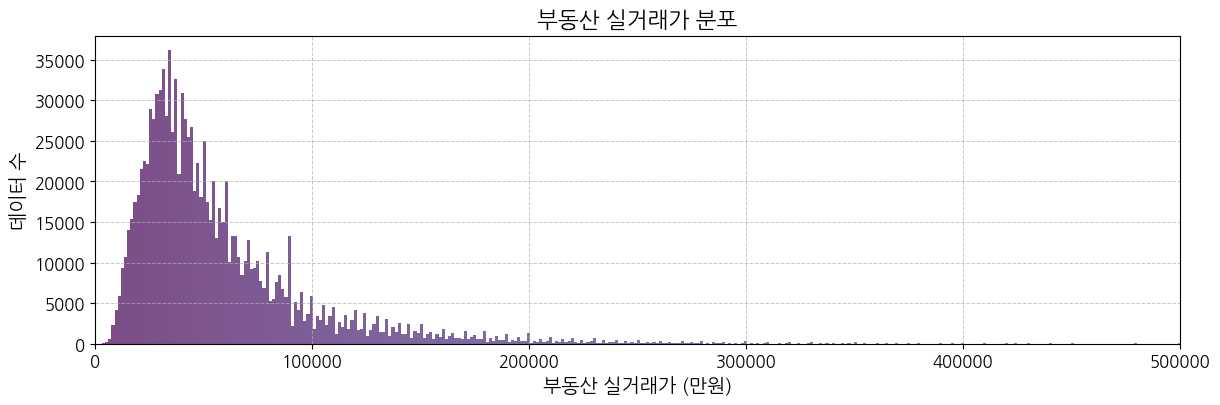

In [86]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['target']].dropna()

# ÏÉâÏÉÅ Îßµ ÏÑ†ÌÉù (viridis)
cmap = plt.get_cmap('viridis')

# Îç∞Ïù¥ÌÑ∞Ïùò minÍ≥º maxÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏÉâÏÉÅ Î≤îÏúÑ Ï†ïÍ∑úÌôî
norm = plt.Normalize(data['target'].min(), data['target'].max())

# ÌûàÏä§ÌÜ†Í∑∏Îû® ÏÉùÏÑ±
plt.figure(figsize=(14, 4))
n, bin_edges, patches = plt.hist(data['target'], bins=1000, alpha=0.7)

# ÏÉâÏÉÅ Ï†ÅÏö©
for patch, edge in zip(patches, bin_edges[:-1]):
    color = cmap(norm(edge))
    patch.set_facecolor(color)

# xÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
plt.xlim(0, 500000)

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Î∂ÑÌè¨', fontsize=16, fontweight='bold')
plt.xlabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (ÎßåÏõê)', fontsize=14)
plt.ylabel('Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()

###  == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- target(Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä) Í∞íÏùò Î∂ÑÌè¨Î•º ÎÇòÌÉÄÎÇ∏ Ï∞®Ìä∏ÏûÑ.
- Ï¢åÏ∏°ÏúºÎ°ú Ïè†Î†§ÏûàÍ≥†, Ïò§Î•∏Ï™ΩÏúºÎ°ú Íº¨Î¶¨Í∞Ä Í∏¥, ÏñëÏùò ÏôúÎèÑ(Right skewed) ÌòïÌÉúÏûÑ.
- 20Ïñµ Ïù¥ÏÉÅÏùò Î∂ÄÎèôÏÇ∞ÏùÄ Îç∞Ïù¥ÌÑ∞ ÏñëÏù¥ Ï†ÅÏúºÎãà, ÏòàÏ∏°Ïù¥ Ïñ¥Î†§Ïö∏ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê®.

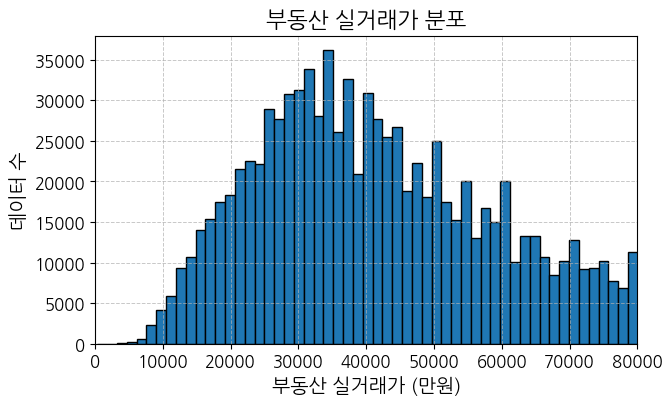

In [87]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: 'target'ÏùÑ Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
data = train[['target']].dropna()

# ÌûàÏä§ÌÜ†Í∑∏Îû®ÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
plt.figure(figsize=(7, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Î∂ÑÌè¨', fontsize=16, fontweight='bold')
plt.xlabel('Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä (ÎßåÏõê)', fontsize=14)
plt.ylabel('Îç∞Ïù¥ÌÑ∞ Ïàò', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 80000)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

### == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- ÏïûÏÑú ÏÇ¥Ìé¥Î≥¥ÏïòÎçò Ï∞®Ìä∏ÏóêÏÑú, Í∞ÄÏû• Îç∞Ïù¥ÌÑ∞Í∞Ä ÎßéÏïòÎçò Î∂ÄÎ∂ÑÎßå ÌôïÎåÄÌïú Ï∞®Ìä∏Ïù¥Îã§.
- 3 ~ 4Ïñµ ÏÇ¨Ïù¥Ïùò Îç∞Ïù¥ÌÑ∞Í∞Ä Í∞ÄÏû• ÎßéÏùå.

In [88]:
print('targetÏùò max: ', train['target'].max())
print('targetÏùò min: ', train['target'].min())

targetÏùò max:  1450000
targetÏùò min:  350


In [89]:
print(train[train['target'] < 1000])

                     ÏãúÍµ∞Íµ¨      Î≤àÏßÄ      Î≥∏Î≤à    Î∂ÄÎ≤à   ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº  \
197746     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏   88.930  200812    1   
197747     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏   83.700  200812    1   
197748     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏   83.700  200812    1   
197749     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏  100.530  200812    1   
197750     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏  100.530  200812    1   
197751     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏   83.700  200812    1   
197752     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏  100.530  200812    1   
197753     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Íµ¨ÏÇ∞Îèô  199-24   199.0  24.0     Ïã†Ìò∏  100.530  200812    1   
197754     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌ

In [90]:
print('Í≥ÑÏïΩÎÖÑÏõîÏùò max: ', train['Í≥ÑÏïΩÎÖÑÏõî'].max())
print('Í≥ÑÏïΩÎÖÑÏõîÏùò min: ', train['Í≥ÑÏïΩÎÖÑÏõî'].min())

Í≥ÑÏïΩÎÖÑÏõîÏùò max:  202306
Í≥ÑÏïΩÎÖÑÏõîÏùò min:  200701


In [91]:
print('ÏïÑÌååÌä∏ Ï¢ÖÎ•ò: ', len(train['ÏïÑÌååÌä∏Î™Ö'].unique()))
display(train['ÏïÑÌååÌä∏Î™Ö'].value_counts()[:10])

ÏïÑÌååÌä∏ Ï¢ÖÎ•ò:  6539


ÌòÑÎåÄ       16644
Ïã†ÎèôÏïÑ      12846
ÌïúÏã†        9074
ÎëêÏÇ∞        8533
Ï£ºÍ≥µ2       7918
Ïö∞ÏÑ±        7768
Î≤ΩÏÇ∞        7285
ÏÇºÏÑ±ÎûòÎØ∏Ïïà     7143
ÎåÄÎ¶º        6305
Í∑πÎèô        5669
Name: ÏïÑÌååÌä∏Î™Ö, dtype: int64

In [92]:
train['Íµ¨'].value_counts()[:10]

ÎÖ∏ÏõêÍµ¨    115099
ÏÜ°ÌååÍµ¨     73785
Í∞ïÎÇ®Íµ¨     69083
Í∞ïÏÑúÍµ¨     66610
Í∞ïÎèôÍµ¨     61895
Íµ¨Î°úÍµ¨     57604
ÏÑ±Î∂ÅÍµ¨     56675
ÏñëÏ≤úÍµ¨     53977
ÏÑúÏ¥àÍµ¨     53126
ÎèÑÎ¥âÍµ¨     52572
Name: Íµ¨, dtype: int64

In [93]:
train['Îèô'].value_counts()[:10]

ÏÉÅÍ≥ÑÎèô    44948
Ï§ëÍ≥ÑÎèô    26357
Ïã†Ï†ïÎèô    24038
Ï∞ΩÎèô     23101
Íµ¨Î°úÎèô    22811
Î¥âÏ≤úÎèô    20511
Î™©Îèô     17246
ÏõîÍ≥ÑÎèô    17056
ÏÑúÏ¥àÎèô    15899
Í≥µÎ¶âÎèô    15763
Name: Îèô, dtype: int64

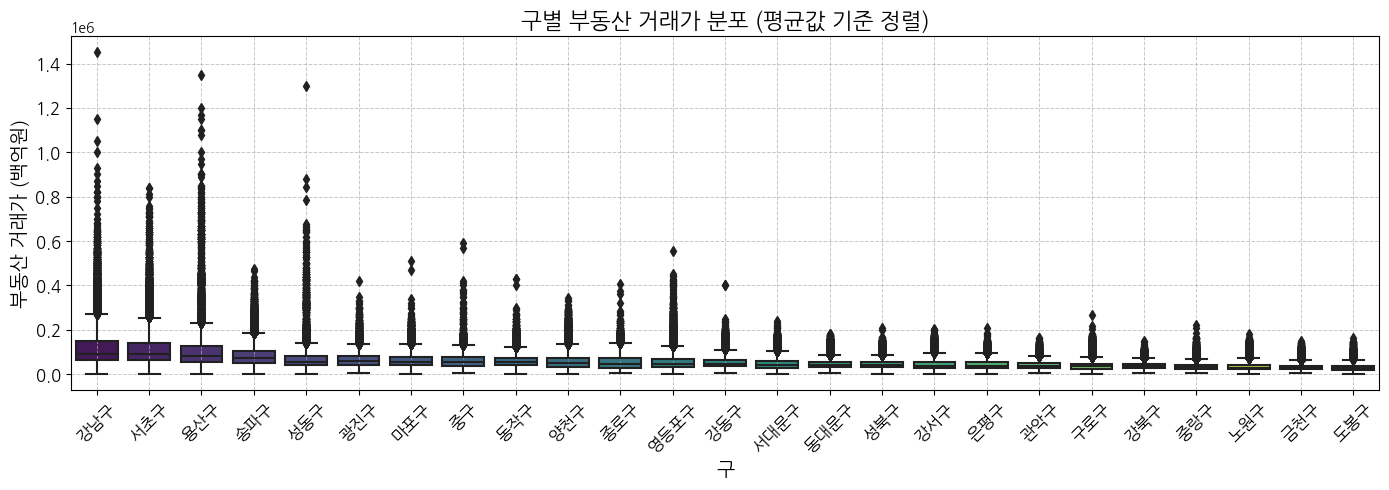

In [94]:
# 'Íµ¨' ÌîºÏ≤òÎ≥ÑÎ°ú 'target'Ïùò ÌèâÍ∑†Í∞íÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
mean_target_by_gu = train.groupby('Íµ¨')['target'].mean().sort_values(ascending=False).reset_index()

# 'Íµ¨'Î≥ÑÎ°ú ÌèâÍ∑†Í∞íÏù¥ ÎÜíÏùÄ ÏàúÏÑúÎ°ú Ï†ïÎ†¨Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
ordered_gu = mean_target_by_gu['Íµ¨']

# Î∞ïÏä§ÌîåÎ°ØÏùÑ Í∑∏Î¶ΩÎãàÎã§.
plt.figure(figsize=(14, 5))

# seabornÏùò boxplotÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
sns.boxplot(x='Íµ¨', y='target', data=train, order=ordered_gu, palette='viridis')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.xlabel('Íµ¨', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÍ∞Ä (Î∞±ÏñµÏõê)', fontsize=14)
plt.title('Íµ¨Î≥Ñ Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÍ∞Ä Î∂ÑÌè¨ (ÌèâÍ∑†Í∞í Í∏∞Ï§Ä Ï†ïÎ†¨)', fontsize=16, fontweight='bold')

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.tight_layout()  # Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï
plt.show()

### == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- Í∞ïÎÇ®Íµ¨, ÏÑúÏ¥àÍµ¨, Ïö©ÏÇ∞Íµ¨, ‚Ä¶ ÏàúÏÑúÎ°ú Î∂ÄÎèôÏÇ∞ Í∞ÄÍ≤©Ïù¥ ÎÜíÏùå.
- Íµ¨ Î≥ÑÎ°ú Î∂ÄÎèôÏÇ∞ Í∞ÄÍ≤© Î∂ÑÌè¨Ïùò Ï∞®Ïù¥Í∞Ä Ïã¨Ìï®.
- ‚ÄòÍµ¨‚Äô, ‚ÄòÎèô‚ÄôÍ≥º Í∞ôÏùÄ Ï£ºÏÜå Î∞è ÏúÑÏπò Ï†ïÎ≥¥Í∞Ä target(Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä) Í∞í ÏòàÏ∏°Ïóê Ï§ëÏöîÌïòÍ≤å ÏûëÏö©Ìï† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê®.


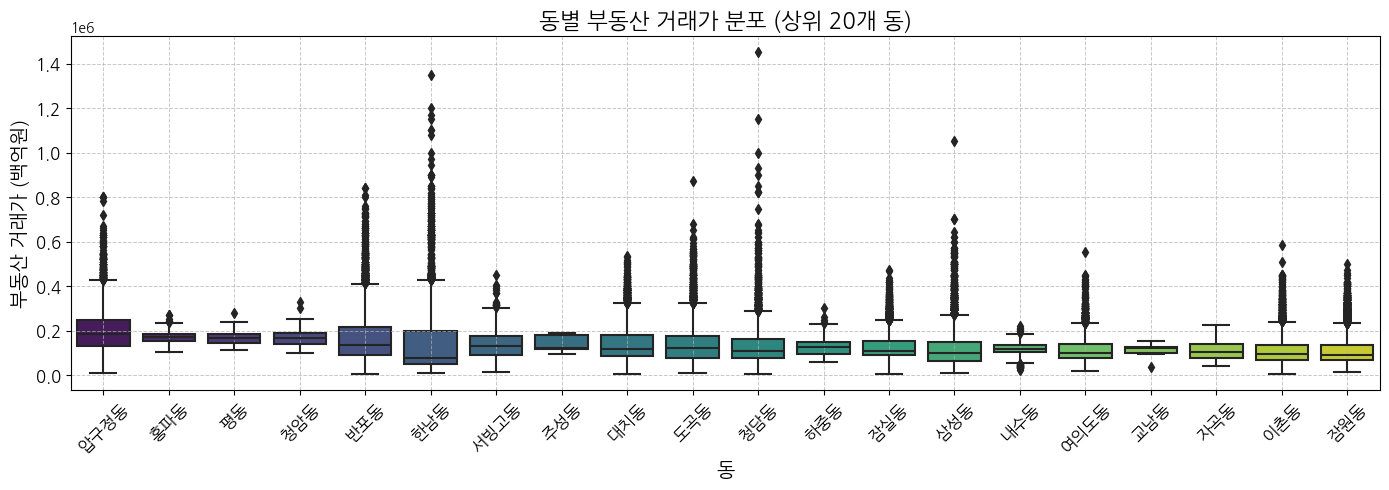

In [95]:
# 'Îèô'ÏúºÎ°ú ÎÅùÎÇòÎäî Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§.
dong_data = train[train['Îèô'].str.endswith('Îèô')]

# 'Îèô' ÌîºÏ≤òÎ≥ÑÎ°ú 'target'Ïùò ÌèâÍ∑†Í∞íÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
mean_target_by_dong = dong_data.groupby('Îèô')['target'].mean().sort_values(ascending=False).reset_index()

# ÌèâÍ∑†Í∞íÏù¥ ÎÜíÏùÄ ÏàúÏÑúÎ°ú ÏÉÅÏúÑ 20Í∞úÏùò 'Îèô'ÏùÑ ÏÑ†ÌÉùÌï©ÎãàÎã§.
top_20_dong = mean_target_by_dong.head(20)['Îèô']

# ÏÉÅÏúÑ 20Í∞úÏùò 'Îèô'Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§.
filtered_train = dong_data[dong_data['Îèô'].isin(top_20_dong)]

# Î∞ïÏä§ÌîåÎ°ØÏùÑ Í∑∏Î¶ΩÎãàÎã§.
plt.figure(figsize=(14, 5))

# seabornÏùò boxplotÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
sns.boxplot(x='Îèô', y='target', data=filtered_train, order=top_20_dong, palette='viridis')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.xlabel('Îèô', fontsize=14)
plt.ylabel('Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÍ∞Ä (Î∞±ÏñµÏõê)', fontsize=14)
plt.title('ÎèôÎ≥Ñ Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÍ∞Ä Î∂ÑÌè¨ (ÏÉÅÏúÑ 20Í∞ú Îèô)', fontsize=16, fontweight='bold')

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.tight_layout()  # Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï
plt.show()

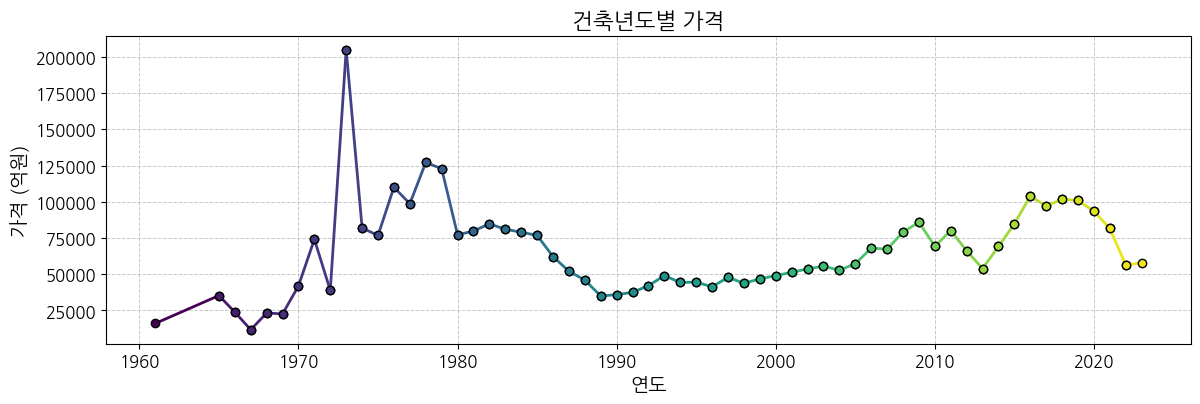

In [96]:
# Í±¥Ï∂ïÎÖÑÎèÑÎ≥Ñ ÌèâÍ∑† Í∞ÄÍ≤© Í≥ÑÏÇ∞
train_yearly = train.groupby(train['Í±¥Ï∂ïÎÖÑÎèÑ'])['target'].mean()

# ÏÉâÏÉÅ Îßµ ÏÑ†ÌÉù
cmap = plt.get_cmap('viridis')

# ÏÉâÏÉÅ ÎßµÏóêÏÑú ÏÉâÏÉÅ Í∞ÄÏ†∏Ïò§Í∏∞
norm = plt.Normalize(train_yearly.index.min(), train_yearly.index.max())
colors = cmap(norm(train_yearly.index))

plt.figure(figsize=(14, 4))

# ÏÑ† Í∑∏Î¶¨Í∏∞
for i in range(len(train_yearly) - 1):
    plt.plot(train_yearly.index[i:i+2], train_yearly.values[i:i+2], color=colors[i], linewidth=2, marker='o', markersize=6, markerfacecolor=colors[i], markeredgecolor='black')

# Ï†úÎ™© Î∞è Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Í±¥Ï∂ïÎÖÑÎèÑÎ≥Ñ Í∞ÄÍ≤©', fontsize=16, fontweight='bold')
plt.xlabel('Ïó∞ÎèÑ', fontsize=14)
plt.ylabel('Í∞ÄÍ≤© (ÏñµÏõê)', fontsize=14)

# xÏ∂ïÍ≥º yÏ∂ï Î†àÏù¥Î∏îÏùò Ìè∞Ìä∏ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Ï∞®Ìä∏ ÌëúÏãú
plt.show()

### == ÏúÑ Ï∞®Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º ==

- 1961ÎÖÑ ~ 2023ÎÖÑ ÏÇ¨Ïù¥Ïóê Í±¥Ï∂ïÎêú Îã§ÏñëÌïú Î∂ÄÎèôÏÇ∞Ïù¥ Ï°¥Ïû¨Ìï®.
- ÏµúÍ∑º Í±¥Ï∂ïÎêú Î∂ÄÎèôÏÇ∞Ïù¥ Ïò§ÎûòÎêú Î∂ÄÎèôÏÇ∞Ïóê ÎπÑÌï¥ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÜíÏùÄ Í∞ÄÍ≤©Ïùº Í≤ÉÏúºÎ°ú ÏòàÏÉÅÌñàÏßÄÎßå,
Í±¥Ï∂ïÎÖÑÎèÑ Îç∞Ïù¥ÌÑ∞ÎßåÏúºÎ°úÎäî Í±∞ÎûòÍ∞ÄÍ≤©Í≥ºÏùò Í≤ΩÌñ•ÏÑ±ÏùÑ Ï∞æÍ∏∞ Ïñ¥Î†§Ïõå Î≥¥ÏûÑ.
Ïò§ÌûàÎ†§, Îã§Î•∏ featureÍ∞Ä Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞ÄÏóê Îçî ÌÅ∞ ÏòÅÌñ•ÏùÑ Ï§Ñ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê®.
- ÎçîÎ∂àÏñ¥, Ïò§ÎûòÎêú Î∂ÄÎèôÏÇ∞ Ï§ëÏóê Í±∞ÎûòÍ∞ÄÍ∞Ä ÍµâÏû•Ìûà ÎÜíÏùÄ Î∂ÄÎ∂ÑÏù¥ Î≥¥Ïù¥ÎäîÎç∞, 1973ÎÖÑÎèÑ Îç∞Ïù¥ÌÑ∞Ïù¥Î©∞, ÌïúÍ∞ïÎ≥ÄÏùò Ïû¨Í±¥Ï∂ï ÎåÄÏÉÅÏù¥Î©¥ÏÑúÎèÑ, ÎπÑÏã∏Í∏∞Î°ú Ïú†Î™ÖÌïú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ Îì±Ïùò Î∂ÄÎèôÏÇ∞Ïù¥ Ìè¨Ìï®Îêú Í≤ÉÏúºÎ°ú ÌôïÏù∏Îê®.

In [97]:
train.groupby('Í±¥Ï∂ïÎÖÑÎèÑ')['target'].mean().idxmax()

1973

In [98]:
train_1973 = train[train['Í±¥Ï∂ïÎÖÑÎèÑ'] == 1973]
train_1973_sorted = train_1973.sort_values(by='target', ascending=False)
display(train_1973_sorted)

ÏãúÍµ∞Íµ¨      Î≤àÏßÄ     Î≥∏Î≤à    Î∂ÄÎ≤à     ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº  \
232768    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô     757  757.0   0.0  Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ   140.13  202209    6   
232767    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô     757  757.0   0.0  Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ   140.13  202209    3   
232761    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô     757  757.0   0.0  Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ   140.13  202205   10   
232760    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô     757  757.0   0.0  Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ   140.13  202205   10   
232763    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Î∞òÌè¨Îèô     757  757.0   0.0  Î∞òÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ   140.13  202205   28   
...                 ...     ...    ...   ...      ...      ...     ...  ...   
1104317  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÎåÄÎ¨∏Íµ¨ ÌôçÏ†úÎèô  157-68  157.0  68.0       Í¥ëÏÇ∞    53.52  200705    3   
1114157   ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏùÄÌèâÍµ¨ Í∞àÌòÑÎèô   467-2  467.0   2.0     Ïó≠Ï¥åÎß®ÏÖò    53.20  200704   10   
1104320  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÎåÄÎ¨∏Íµ¨ ÌôçÏ†úÎèô  157-68  157.0  68.0       Í¥ëÏÇ∞    52.53  200709    3   
1104316  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÎåÄÎ¨∏Íµ¨ ÌôçÏ†úÎèô  157-68  157.0  68.0       Í¥ëÏÇ∞    52.53  200704    7   
637006    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Ïö©ÏÇ∞Íµ¨ ÌõÑÏïîÎèô     426  426.0   0.0      Îâ¥ÌõÑÏïî    67.11  201510    1   

         Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ       ÎèÑÎ°úÎ™Ö     Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê  Í±∞ÎûòÏú†Ìòï  Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ  \
232768   3  1973    Ïã†Î∞òÌè¨Î°ú 9         NaN         Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨   
232767   5  1973    Ïã†Î∞òÌè¨Î°ú 9         NaN         Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨   
232761   4  1973   Ïã†Î∞òÌè¨Î°ú 45         NaN         Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨   
232760   4  1973   Ïã†Î∞òÌè¨Î°ú 45  20220627.0         Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨   
232763   2  1973   Ïã†Î∞òÌè¨Î°ú 45         NaN         Ï§ëÍ∞úÍ±∞Îûò  ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨   
...     ..   ...       ...         ...    ...   ...     ...   
1104317  3  1973  Î™®ÎûòÎÇ¥Î°ú 455         NaN            -       -   
1114157  4  1973  Ïó∞ÏÑúÎ°ú19Í∏∏ 9         NaN            -       -   
1104320  6  1973  Î™®ÎûòÎÇ¥Î°ú 455         NaN            -       -   
1104316  6  1973  Î™®ÎûòÎÇ¥Î°ú 455         NaN            -       -   
637006   3  1973    ÌõÑÏïîÎ°ú 71         NaN            -       -   

        k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±) k-Ï†ÑÌôîÎ≤àÌò∏ k-Ìå©Ïä§Î≤àÌò∏  Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú) k-Í¥ÄÎ¶¨Î∞©Ïãù  \
232768                 NaN    NaN    NaN         NaN          NaN    NaN   
232767                 NaN    NaN    NaN         NaN          NaN    NaN   
232761                 NaN    NaN    NaN         NaN          NaN    NaN   
232760                 NaN    NaN    NaN         NaN          NaN    NaN   
232763                 NaN    NaN    NaN         NaN          NaN    NaN   
...                    ...    ...    ...         ...          ...    ...   
1104317                NaN    NaN    NaN         NaN          NaN    NaN   
1114157                NaN    NaN    NaN         NaN          NaN    NaN   
1104320                NaN    NaN    NaN         NaN          NaN    NaN   
1104316                NaN    NaN    NaN         NaN          NaN    NaN   
637006                 NaN    NaN    NaN         NaN          NaN    NaN   

        k-Î≥µÎèÑÏú†Ìòï k-ÎÇúÎ∞©Î∞©Ïãù  k-Ï†ÑÏ≤¥ÎèôÏàò  k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨) k-ÏãúÌñâÏÇ¨ k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº  k-Ïó∞Î©¥Ï†Å  \
232768     NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
232767     NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
232761     NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
232760     NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
232763     NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
...        ...    ...     ...      ...        ...   ...           ...    ...   
1104317    NaN    NaN     NaN      NaN        NaN   NaN           NaN    NaN   
1114157    Na

In [99]:
train['ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò'] = train['Ï£ºÏ∞®ÎåÄÏàò'] / train['k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò']
test['ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò'] = test['Ï£ºÏ∞®ÎåÄÏàò'] / test['k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò']

In [100]:
# 'Îèô+ÏïÑÌååÌä∏Î™Ö' Í∏∞Ï§ÄÏúºÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ 'target' ÌîºÏ≤òÏùò ÌèâÍ∑† Í∞ÄÍ≤© Í≥ÑÏÇ∞
mean_target_per_group = train.groupby('Îèô+ÏïÑÌååÌä∏Î™Ö')['target'].mean()

# ÌèâÍ∑† Í∞ÄÍ≤©Ïù¥ 200,000 Ïù¥ÏÉÅÏù∏ Í∑∏Î£πÏùÑ Î¶¨Ïä§Ìä∏Î°ú ÏÉùÏÑ±
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train Îç∞Ïù¥ÌÑ∞Ïóê 'top_apt' ÌîºÏ≤ò Ï∂îÍ∞Ä
train['top_apt'] = train['Îèô+ÏïÑÌååÌä∏Î™Ö'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test Îç∞Ïù¥ÌÑ∞Ïóê 'top_apt' ÌîºÏ≤ò Ï∂îÍ∞Ä
test['top_apt'] = test['Îèô+ÏïÑÌååÌä∏Î™Ö'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [101]:
train['Íµ≠ÎØºÌèâÏàò'] = train['Ï†ÑÏö©Î©¥Ï†Å(„é°)'].apply(lambda x: 1 if x <= 90 else 0)

In [102]:
selected_feature_list = ['ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'Íµ¨', 'Îèô', 'ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'target', 'top_apt', 'Íµ≠ÎØºÌèâÏàò', '1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ', '1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨', 'kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)', 'k-135„é°Ï¥àÍ≥º']
train = train[selected_feature_list]

In [103]:
print((train.isnull().mean() * 100).to_string())

ÏïÑÌååÌä∏Î™Ö                       0.190021
Ï†ÑÏö©Î©¥Ï†Å(„é°)                    0.000000
ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú                   5.252578
Ï∏µ                          0.000000
Í±¥Ï∂ïÎÖÑÎèÑ                       0.000000
Íµ¨                          0.000000
Îèô                          0.000000
ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò                   22.778333
Ï¢åÌëúX                        0.000000
Ï¢åÌëúY                        0.000000
target                     0.000000
top_apt                    0.000000
Íµ≠ÎØºÌèâÏàò                       0.000000
1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ               0.000000
1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨               0.000000
kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò                    5.252578
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)        22.586167
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)    22.586167
k-135„é°Ï¥àÍ≥º                  99.970773


In [104]:
def impute_missing_values(df):
    # ÏàòÏπòÌòï ÌîºÏ≤òÏôÄ Î≤îÏ£ºÌòï ÌîºÏ≤ò Íµ¨Î∂Ñ
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # ÏàòÏπòÌòï ÌîºÏ≤òÏùò Í≤∞Ï∏°ÏπòÎ•º ÌèâÍ∑†Í∞íÏúºÎ°ú ÎåÄÏ≤¥
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # ÏàòÏπòÌòï ÌîºÏ≤òÏùò Í≤∞Ï∏°ÏπòÎ•º -999ÏúºÎ°ú ÎåÄÏ≤¥
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # Î≤îÏ£ºÌòï ÌîºÏ≤òÏùò Í≤∞Ï∏°ÏπòÎ•º 'Missing'ÏúºÎ°ú ÎåÄÏ≤¥
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)  ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ    Íµ¨    Îèô   ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò         Ï¢åÌëúX  \
0        Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  282438.7   3  1987  Í∞ïÎÇ®Íµ¨  Í∞úÌè¨Îèô  0.970370  127.056859   
1        Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  282438.7   4  1987  Í∞ïÎÇ®Íµ¨  Í∞úÌè¨Îèô  0.970370  127.056859   
2        Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    54.98  282438.7   5  1987  Í∞ïÎÇ®Íµ¨  Í∞úÌè¨Îèô  0.970370  127.056859   
3        Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  283669.8   4  1987  Í∞ïÎÇ®Íµ¨  Í∞úÌè¨Îèô  0.970370  127.056859   
4        Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  283669.8   2  1987  Í∞ïÎÇ®Íµ¨  Í∞úÌè¨Îèô  0.970370  127.056859   
...         ...      ...       ...  ..   ...  ...  ...       ...         ...   
1118817    Í∞àÌòÑÌòÑÎåÄ    59.94    -999.0  11  1998  ÏùÄÌèâÍµ¨  Íµ¨ÏÇ∞Îèô  1.000000  126.905543   
1118818    Í∞àÌòÑÌòÑÎåÄ    59.94    -999.0  10  1998  ÏùÄÌèâÍµ¨  Íµ¨ÏÇ∞Îèô  1.000000  126.905543   
1118819    Í∞àÌòÑÌòÑÎåÄ    84.83    -999.0  20  1998  ÏùÄÌèâÍµ¨  Íµ¨ÏÇ∞Îèô  1.000000  126.905543   
1118820    Í∞àÌòÑÌòÑÎåÄ    84.83    -999.0   8  1998  ÏùÄÌèâÍµ¨  Íµ¨ÏÇ∞Îèô  1.000000  126.905543   
1118821      Î¨µÏ†ï    52.46    -999.0   5  1981   Ï§ëÍµ¨  Î¨µÏ†ïÎèô  0.368852  127.000034   

               Ï¢åÌëúY  target top_apt  Íµ≠ÎØºÌèâÏàò 1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ  1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨  kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò  \
0        37.476276  124000       0     1           Íµ¨Î£°   1187.672025     88.4   
1        37.476276  123500       0     1           Íµ¨Î£°   1187.672025     88.4   
2        37.476276   91500       0     1           Íµ¨Î£°   1187.672025     88.4   
3        37.476276  130000       0     1           Íµ¨Î£°   1187.672025    118.0   
4        37.476276  117000       0     1           Íµ¨Î£°   1187.672025    118.0   
...            ...     ...     ...   ...          ...           ...      ...   
1118817  37.612989   20000       0     1           Íµ¨ÏÇ∞   1048.367837   -999.0   
1118818  37.612989   20000       0     1           Íµ¨ÏÇ∞   1048.367837   -999.0   
1118819  37.612989   28000       0     1           Íµ¨ÏÇ∞   1048.367837   -999.0   
1118820  37.612989   29000       0     1           Íµ¨ÏÇ∞   1048.367837   -999.0   
1118821  37.560695   13250       0     1         ÎèôÎåÄÏûÖÍµ¨    523.705597   -999.0   

         k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)  k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)  k-135„é°Ï¥àÍ≥º  
0                      20.0                   250.0    -999.0  
1                      20.0                   250.0    -999.0  
2                      20.0                   250.0    -999.0  
3                      20.0                   250.0    -999.0  
4                      20.0                   250.0    -999.0  
...                     ...                     ...       ...  
1118817               171.0                   141.0    -999.0  
1118818               171.0                   141.0    -999.0  
1118819               171.0                   141.0    -999.0  
1118820               171.0                   141.0    -999.0  
1118821               121.0                     0.0    -999.0  

[1118822 rows x 19 columns]

In [105]:
print((train.isnull().mean() * 100).to_string())

ÏïÑÌååÌä∏Î™Ö                      0.0
Ï†ÑÏö©Î©¥Ï†Å(„é°)                   0.0
ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú                  0.0
Ï∏µ                         0.0
Í±¥Ï∂ïÎÖÑÎèÑ                      0.0
Íµ¨                         0.0
Îèô                         0.0
ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò                   0.0
Ï¢åÌëúX                       0.0
Ï¢åÌëúY                       0.0
target                    0.0
top_apt                   0.0
Íµ≠ÎØºÌèâÏàò                      0.0
1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ              0.0
1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨              0.0
kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò                   0.0
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)        0.0
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)    0.0
k-135„é°Ï¥àÍ≥º                  0.0


In [106]:
train = train[~train['Ï∏µ'].isin([-2, 65, 67, 68, 69])]

In [107]:
# train = train[train['Í≥ÑÏïΩÎÖÑÏõî'] >= 201801]

In [115]:
train['Íµ≠ÎØºÌèâÏàò'] = train['Íµ≠ÎØºÌèâÏàò'].astype('category')

SEED = 1053682552

# TARGET Ï†ïÏùò
TARGET = 'target'

# NUMERIC_COLS Í≥ÑÏÇ∞: TARGETÏùÑ Ï†úÏô∏Ìïú ÏàòÏπòÌòï Ïª¨Îüº Î¶¨Ïä§Ìä∏
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS Í≥ÑÏÇ∞: NUMERIC_COLSÎ•º Ï†úÏô∏Ìïú ÎÇòÎ®∏ÏßÄ Ïª¨Îüº Î¶¨Ïä§Ìä∏
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò', 'Ï¢åÌëúX', 'Ï¢åÌëúY', '1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨', 'kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)', 'k-135„é°Ï¥àÍ≥º']
Categoric Cols --> ['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô', 'top_apt', 'Íµ≠ÎØºÌèâÏàò', '1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Ïù¥Î¶Ñ']


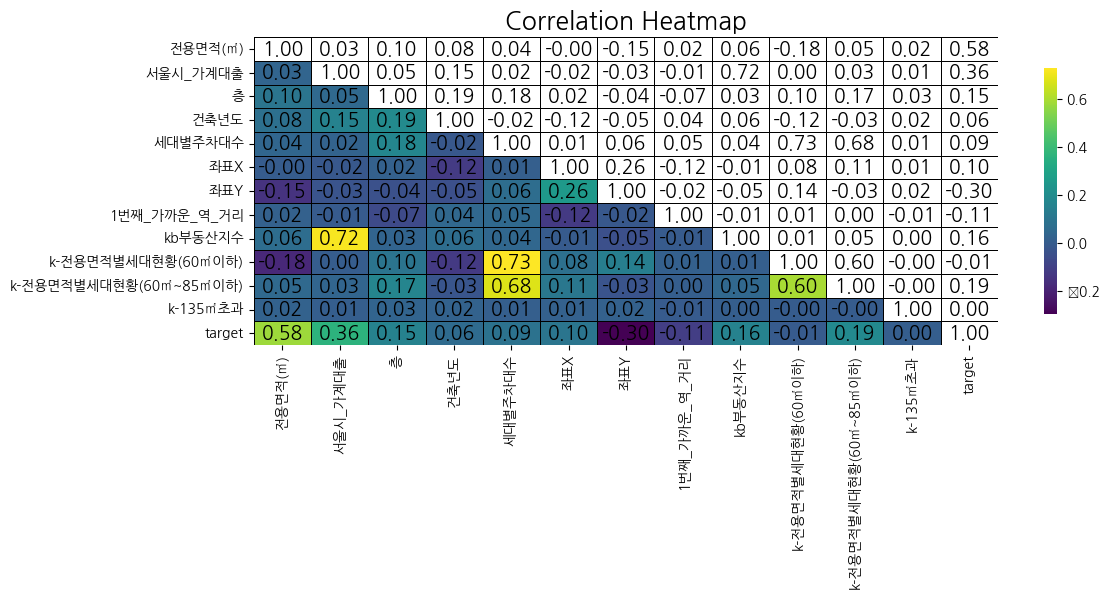

In [116]:
# ÏÉÅÍ¥Ä ÌñâÎ†¨ Í≥ÑÏÇ∞
corr = train[NUMERIC_COLS + [TARGET]].corr()

# ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(12, 4))  # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ Ï°∞Ï†ï
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# Í∞Å ÏÖÄÏóê Ïà´Ïûê Ï∂îÍ∞Ä
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # Í∏ÄÏûêÏÉâ Í≤ÄÏùÄÏÉâ
                fontsize=14,    # Í∏ÄÏûê ÌÅ¨Í∏∞ Ï°∞Ï†ï
                fontweight='bold')  # Í∏ÄÏûê ÍµµÍ≤å

# ÌÉÄÏù¥ÌãÄ Ï∂îÍ∞Ä
plt.title('Correlation Heatmap', size=18)

# Í∑∏ÎûòÌîÑ ÌëúÏãú
plt.show()

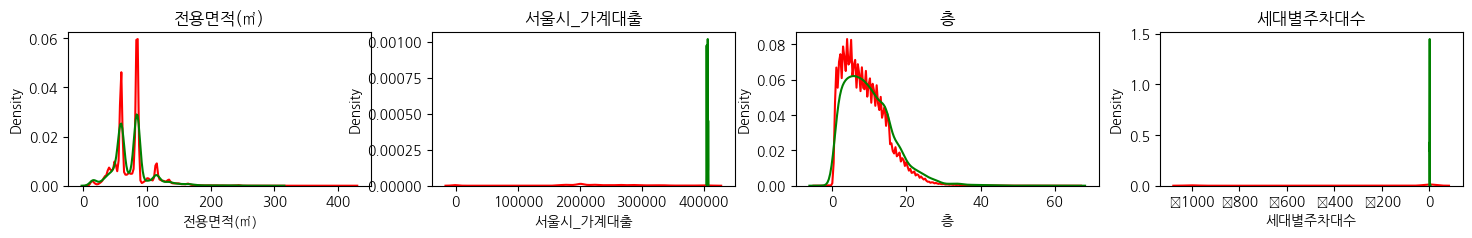

In [117]:
col_list = ['Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú', 'Ï∏µ', 'ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò']

n_cols = len(col_list)
n_rows = math.ceil(len(col_list)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(18, 2))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.2)
for i,c in enumerate(col_list):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(col_list),len(ax)):
    ax[j].axis('off')
plt.show()
    

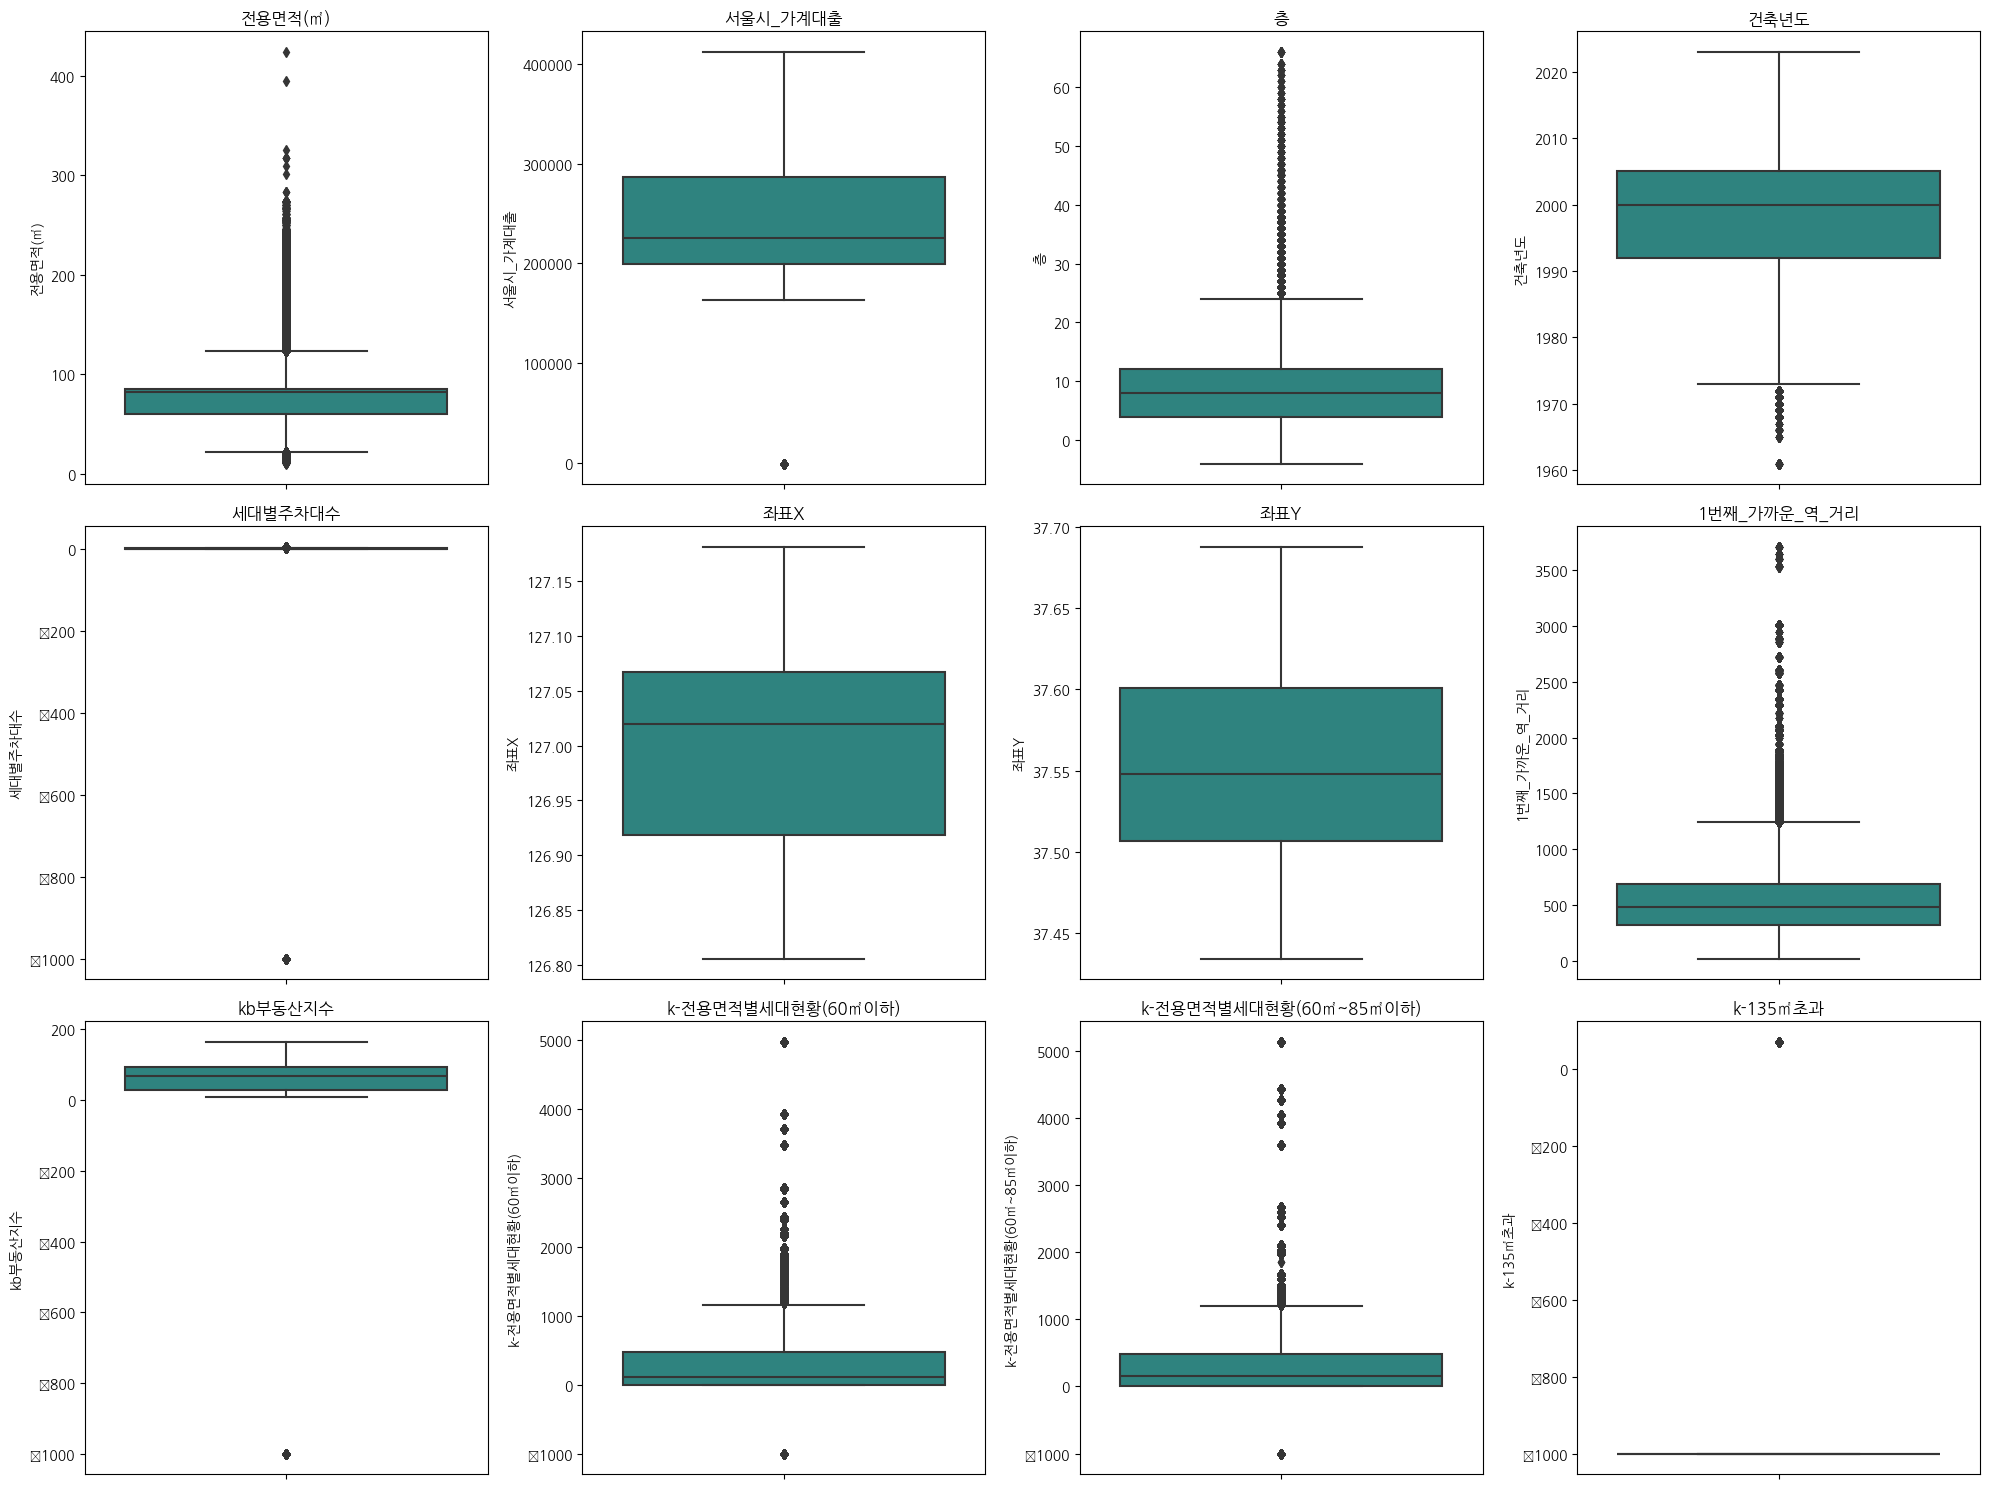

In [119]:
col_list = ['Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'ÏÑúÏö∏Ïãú_Í∞ÄÍ≥ÑÎåÄÏ∂ú', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÏÑ∏ÎåÄÎ≥ÑÏ£ºÏ∞®ÎåÄÏàò', 'Ï¢åÌëúX', 'Ï¢åÌëúY', '1Î≤àÏß∏_Í∞ÄÍπåÏö¥_Ïó≠_Í±∞Î¶¨', 'kbÎ∂ÄÎèôÏÇ∞ÏßÄÏàò', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)', 'k-135„é°Ï¥àÍ≥º']

# ÏàòÏπòÌòï ÌîºÏ≤òÎì§Ïóê ÎåÄÌïú Î∞ïÏä§ ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Í∞Å ÏàòÏπòÌòï ÌîºÏ≤òÏóê ÎåÄÌï¥ Î∞ïÏä§ ÌîåÎ°ØÏùÑ Í∑∏Î¶ΩÎãàÎã§.
for ax, column in zip(axes.flatten(), col_list):
    sns.boxplot(data=train, y=column, ax=ax, palette="viridis")
    ax.set_title(f'{column}')

# ÎÇòÎ®∏ÏßÄ Îπà ÌîåÎ°ØÎì§ Ïà®Í∏∞Í∏∞
for i in range(len(col_list), 3 * 4):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()